# `IN` Práctica 2. Análisis relacional mediante segmentación

Miguel Ángel Fernández Gutiérrez <<mianfg@correo.ugr.es>>

## Caso 1. Ayudas a hogares andaluces

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

from sklearn import preprocessing as sk_preprocessing
from sklearn.impute import SimpleImputer
from sklearn.manifold import MDS
from math import floor

import cluster, visualization, common
from cluster import ClusterAlgorithm

mpl.rcParams['figure.dpi'] = 120

Leemos el _dataset_, los usaremos en todos los casos:

In [2]:
data = pd.read_csv('./data/datos_hogar_2020.csv')

**Filtrado:** hogares andaluces

In [3]:
case = data[data['DB040']=='ES61']

**Selección de variables** y renombrado

In [6]:
case_columns = {
    'HY020': 'renta_disponible',
    'HY050N': 'ayuda_familia_hijos',
    'HY060N': 'asistencia_social',
    'HY070N': 'ayuda_vivienda'
}
case = case.rename(columns=case_columns)
case = case[case_columns.values()]
case

,renta_disponible,ayuda_familia_hijos,asistencia_social,ayuda_vivienda
92,14132.80,0.0,0.0,0.0
93,11090.61,0.0,0.0,0.0
94,43348.10,0.0,0.0,0.0
95,17430.90,0.0,0.0,0.0
96,9513.90,0.0,0.0,0.0
...,...,...,...,...
12919,44908.24,0.0,0.0,0.0
12920,77438.70,0.0,0.0,0.0
12921,55490.90,0.0,0.0,0.0
12922,49166.20,0.0,0.0,0.0


**Valores perdidos:** no hay valores perdidos

In [7]:
case.isna().sum()

renta_disponible       0
ayuda_familia_hijos    0
asistencia_social      0
ayuda_vivienda         0
dtype: int64

**Valores nulos:** hay muchos valores que son 0

_**Nota:** a continuación se muestran, fijada la variable, el número de instancias que tienen su valor no nulo._

In [8]:
case.astype(bool).sum(axis=0)

renta_disponible       1600
ayuda_familia_hijos      48
asistencia_social        97
ayuda_vivienda           20
dtype: int64

**Instanciamos y ejecutamos los algoritmos**

In [9]:
algorithms = [
    ClusterAlgorithm(KMeans, name='K-Means', init='k-means++', n_clusters=5, n_init=5, random_state=common.RANDOM_SEED, centroid_attr="cluster_centers_"),
    ClusterAlgorithm(Birch, name='Birch', branching_factor=25, threshold=0.15, n_clusters=5, centroid_attr="subcluster_centers_"),
    ClusterAlgorithm(DBSCAN, name='DBSCAN', eps=0.15, min_samples=5),
    ClusterAlgorithm(MeanShift, name='MeanShift', centroid_attr="cluster_centers_"),
    ClusterAlgorithm(AgglomerativeClustering, name='Ward', n_clusters=5, linkage='ward')
]

In [10]:
print("Algoritmos a usar:\n")

for algorithm in algorithms:
    print(algorithm.__repr__())

Algoritmos a usar:

<ClusterAlgorithm [K-Means], 1 instance:
	init=k-means++, n_clusters=5, n_init=5, random_state=19122000>
<ClusterAlgorithm [Birch], 1 instance:
	branching_factor=25, threshold=0.15, n_clusters=5>
<ClusterAlgorithm [DBSCAN], 1 instance:
	eps=0.15, min_samples=5>
<ClusterAlgorithm [MeanShift], 1 instance:
	(no parameters)>
<ClusterAlgorithm [Ward], 1 instance:
	n_clusters=5, linkage=ward>


In [11]:
print("Ejecutando instancias...\n")

for algorithm in algorithms:
    algorithm.run_instances(case, verbose=True)

Ejecutando instancias...

[K-Means] Running instance init=k-means++, n_clusters=5, n_init=5, random_state=19122000...
[K-Means] Instances run successfully
[Birch] Running instance branching_factor=25, threshold=0.15, n_clusters=5...
[Birch] Instances run successfully
[DBSCAN] Running instance eps=0.15, min_samples=5...
[DBSCAN] Instances run successfully
[MeanShift] Running instance (no parameters)...
[MeanShift] Instances run successfully
[Ward] Running instance n_clusters=5, linkage=ward...
[Ward] Instances run successfully


In [12]:
print("Calculando métricas:\n")

for algorithm in algorithms:
    algorithm.calculate_metrics(cluster.metrics, verbose=True)

Calculando métricas:

[K-Means] Calculating metrics in instance init=k-means++, n_clusters=5, n_init=5, random_state=19122000...
[K-Means] Metrics calculated successfully
[Birch] Calculating metrics in instance branching_factor=25, threshold=0.15, n_clusters=5...
[Birch] Metrics calculated successfully
[DBSCAN] Calculating metrics in instance eps=0.15, min_samples=5...
[DBSCAN] Metrics calculated successfully
[MeanShift] Calculating metrics in instance (no parameters)...
[MeanShift] Metrics calculated successfully
[Ward] Calculating metrics in instance n_clusters=5, linkage=ward...
[Ward] Metrics calculated successfully


In [13]:
case_metrics = pd.DataFrame(columns=cluster.metrics.keys())
for algorithm in algorithms:
    case_metrics.loc[algorithm.algorithm_name] = algorithm.instances[0]['metrics']
case_metrics

,Tiempo,Calinski-Harabasz,Davies-Bouldin,Silhouette,Número de clusters
K-Means,0.160300,1348.639476,0.637565,0.481568,5
Birch,0.087501,256.611475,0.678905,0.550564,5
DBSCAN,0.129545,159.220980,1.043619,0.814450,2
MeanShift,22.247592,179.696538,0.433546,0.393259,22
Ward,0.143143,1081.540804,0.775540,0.406924,5


### Específico de Ward

In [34]:
cluster.ward_specific(algorithms[4].instances[0])

Ward filtering applied (min_size=10):
 - Number of clusters before filtering: 5
 - Number of clusters after filtering:  5
 - Size of dataset before filtering:    1608
 - Size of dataset after filtering:     1608



### Visualización

#### Heatmaps

##### K-Means

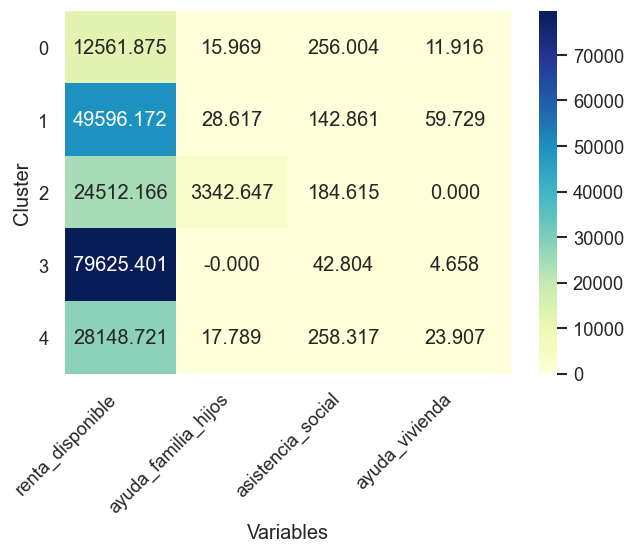

<Figure size 720x480 with 0 Axes>

In [14]:
visualization.plot_heatmap(algorithms[0].instances[0])

##### Birch

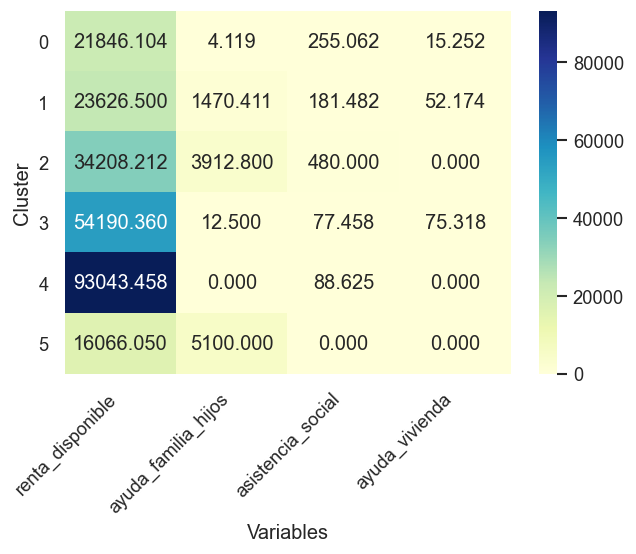

<Figure size 720x480 with 0 Axes>

In [15]:
visualization.plot_heatmap(algorithms[1].instances[0])

##### DBSCAN

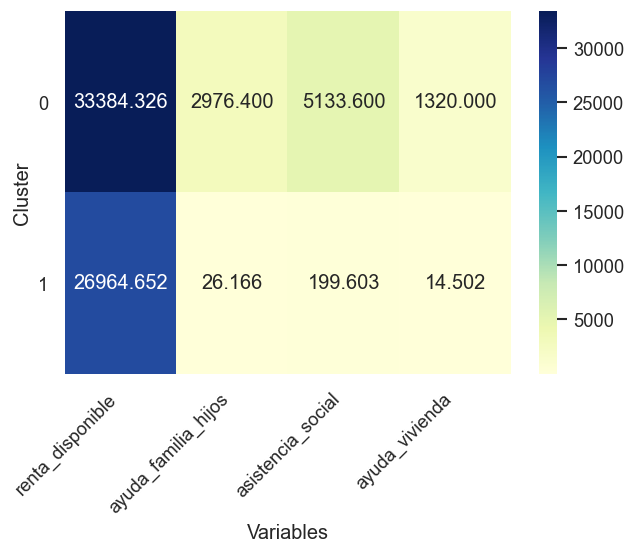

<Figure size 720x480 with 0 Axes>

In [16]:
visualization.plot_heatmap(algorithms[2].instances[0])

##### Mean Shift

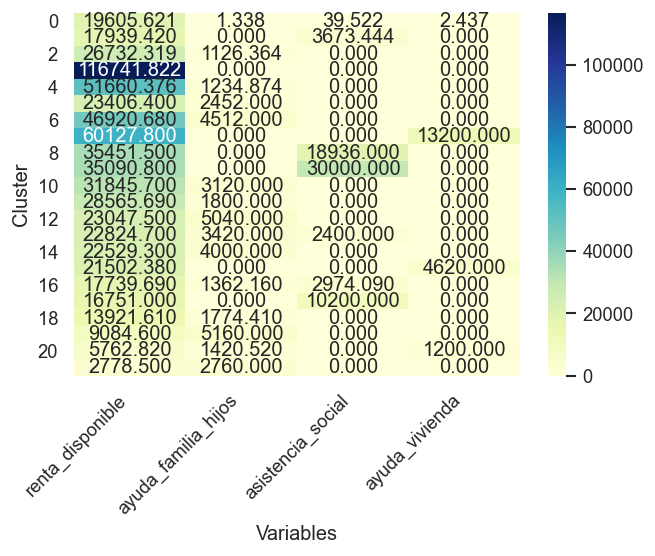

<Figure size 720x480 with 0 Axes>

In [17]:
visualization.plot_heatmap(algorithms[3].instances[0])

##### Ward

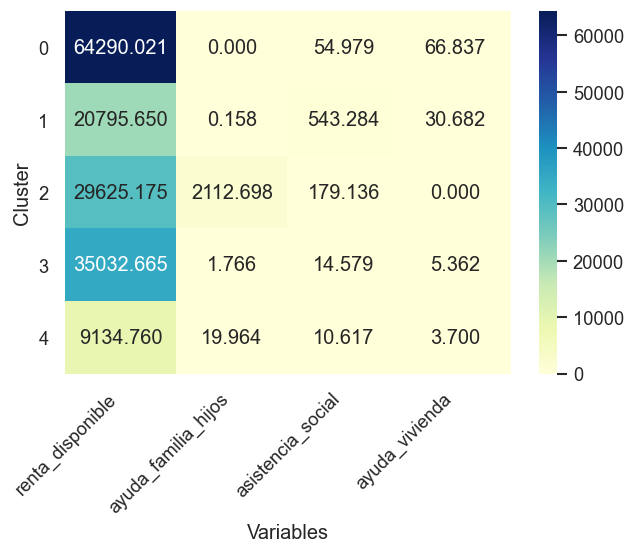

<Figure size 720x480 with 0 Axes>

In [18]:
visualization.plot_heatmap(algorithms[4].instances[0])

#### Cluster sizes

##### K-Means

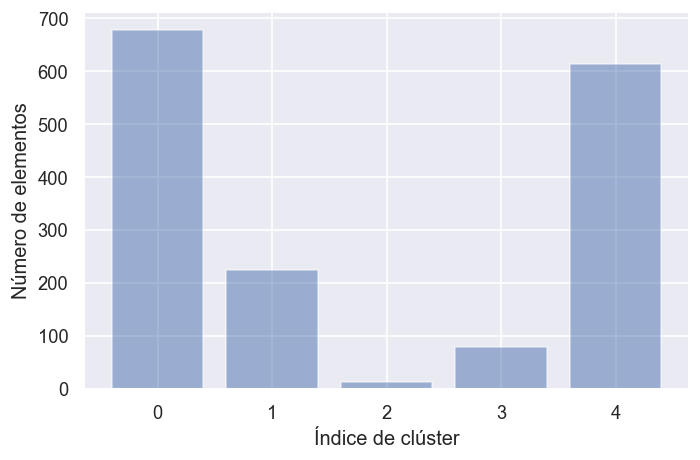

In [19]:
visualization.plot_cluster_sizes(algorithms[0].instances[0])

##### Birch

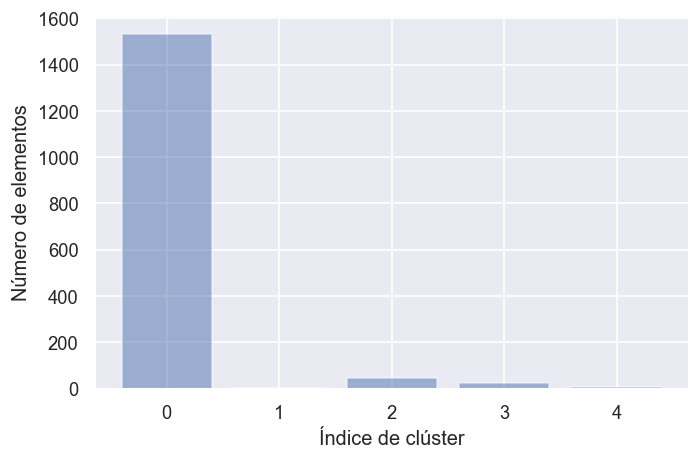

In [20]:
visualization.plot_cluster_sizes(algorithms[1].instances[0])

##### DBSCAN

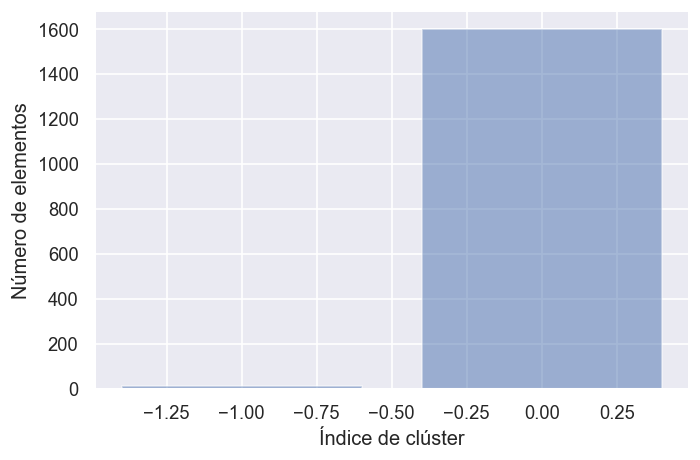

In [21]:
visualization.plot_cluster_sizes(algorithms[2].instances[0])

In [162]:
algorithms[2].instances[0]['X_clusters'].groupby(['cluster']).size()

cluster
-1      10
 0    1598
dtype: int64

##### Mean Shift

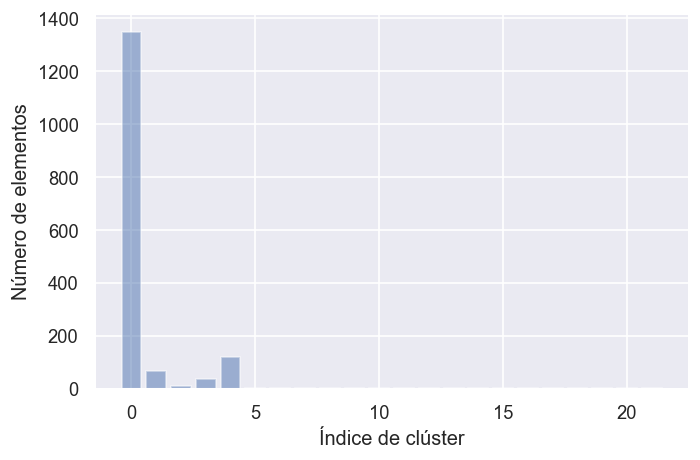

In [22]:
visualization.plot_cluster_sizes(algorithms[3].instances[0])

##### Ward

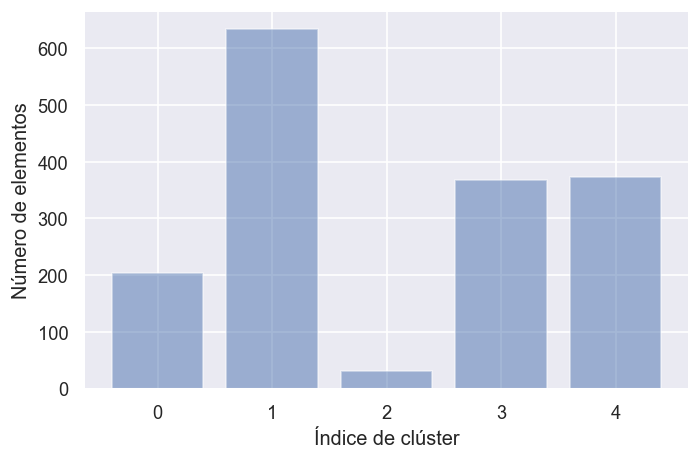

In [23]:
visualization.plot_cluster_sizes(algorithms[4].instances[0])

#### Scatter matrix

##### K-Means

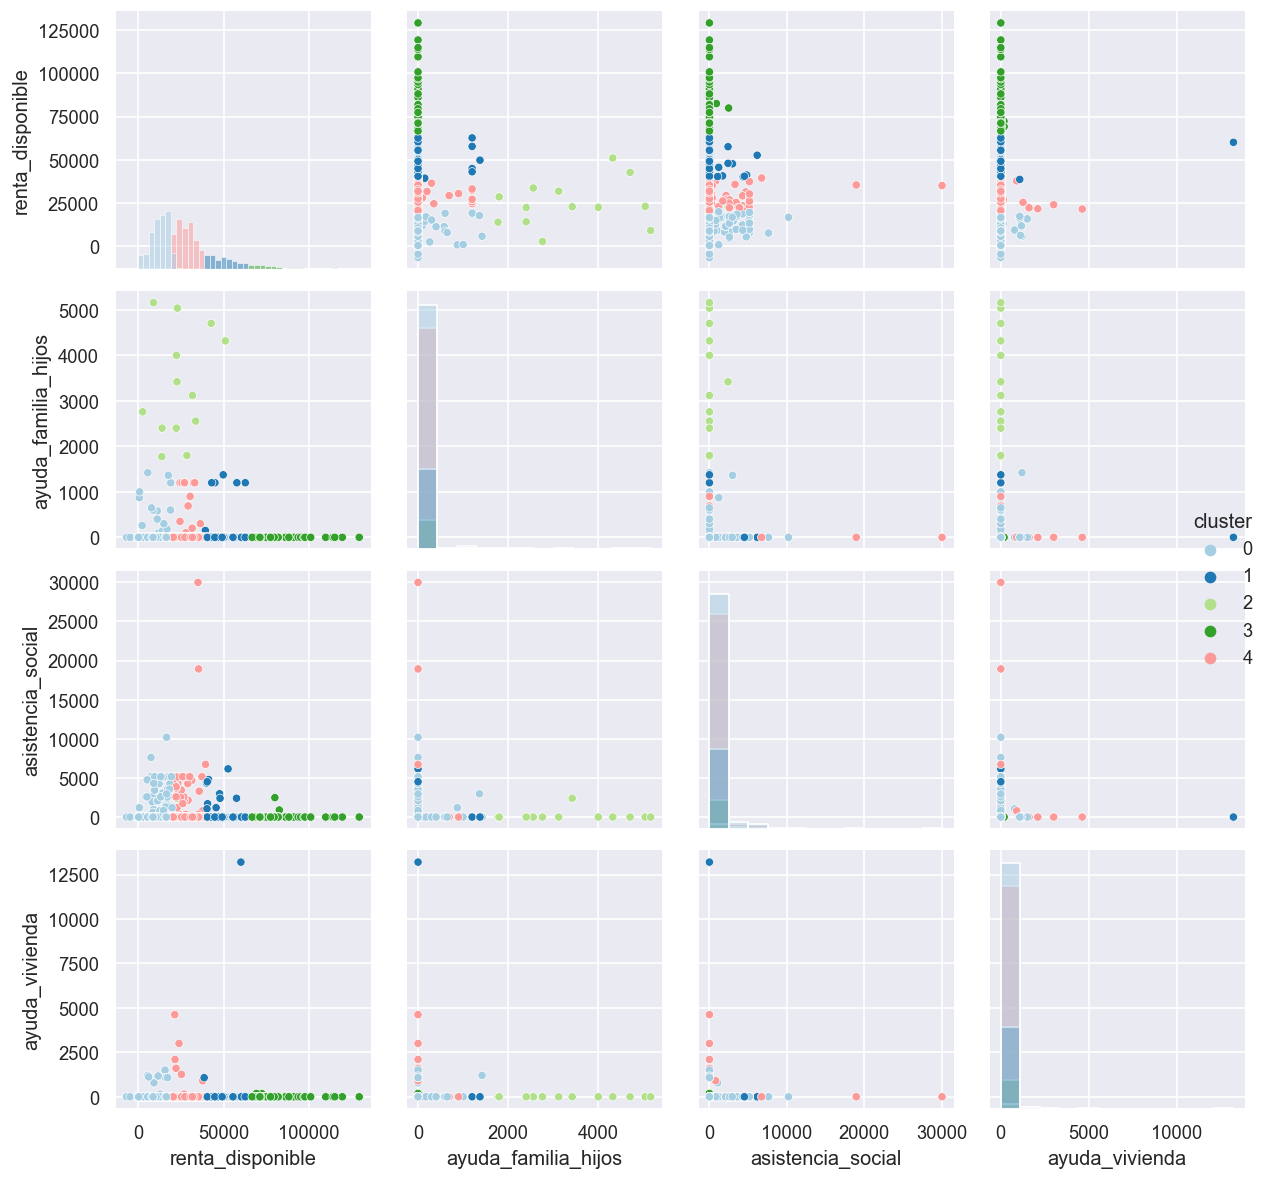

<Figure size 720x480 with 0 Axes>

In [24]:
visualization.plot_scatter_matrix(algorithms[0].instances[0])

##### Birch

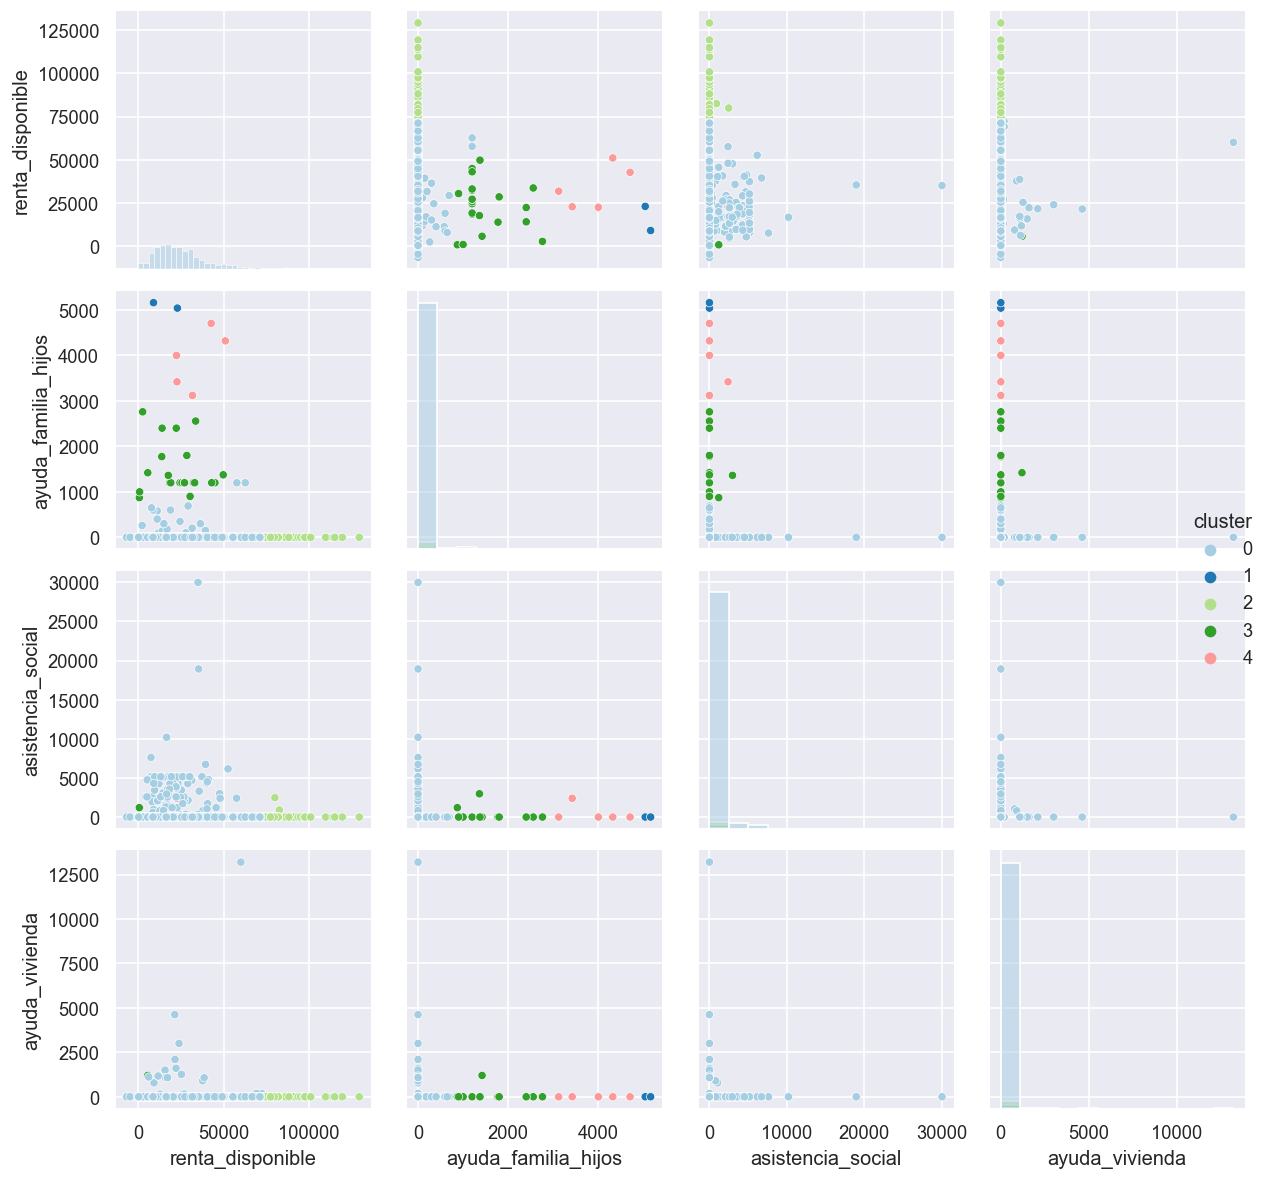

<Figure size 720x480 with 0 Axes>

In [25]:
visualization.plot_scatter_matrix(algorithms[1].instances[0])

##### DBSCAN

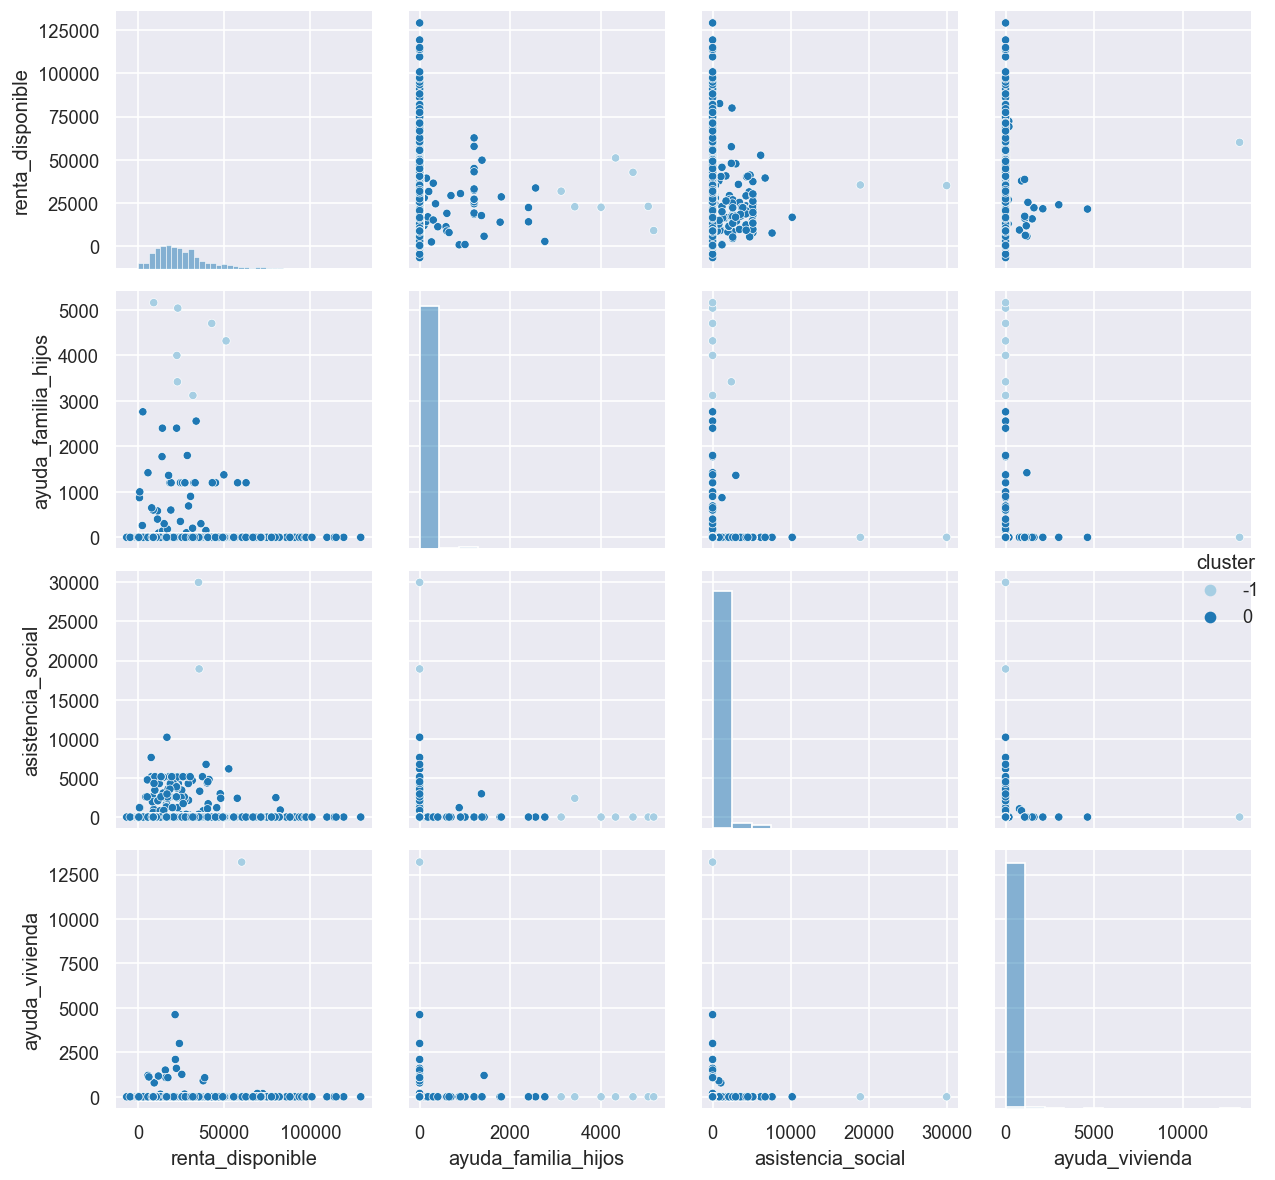

<Figure size 720x480 with 0 Axes>

In [26]:
visualization.plot_scatter_matrix(algorithms[2].instances[0])

##### Mean Shift

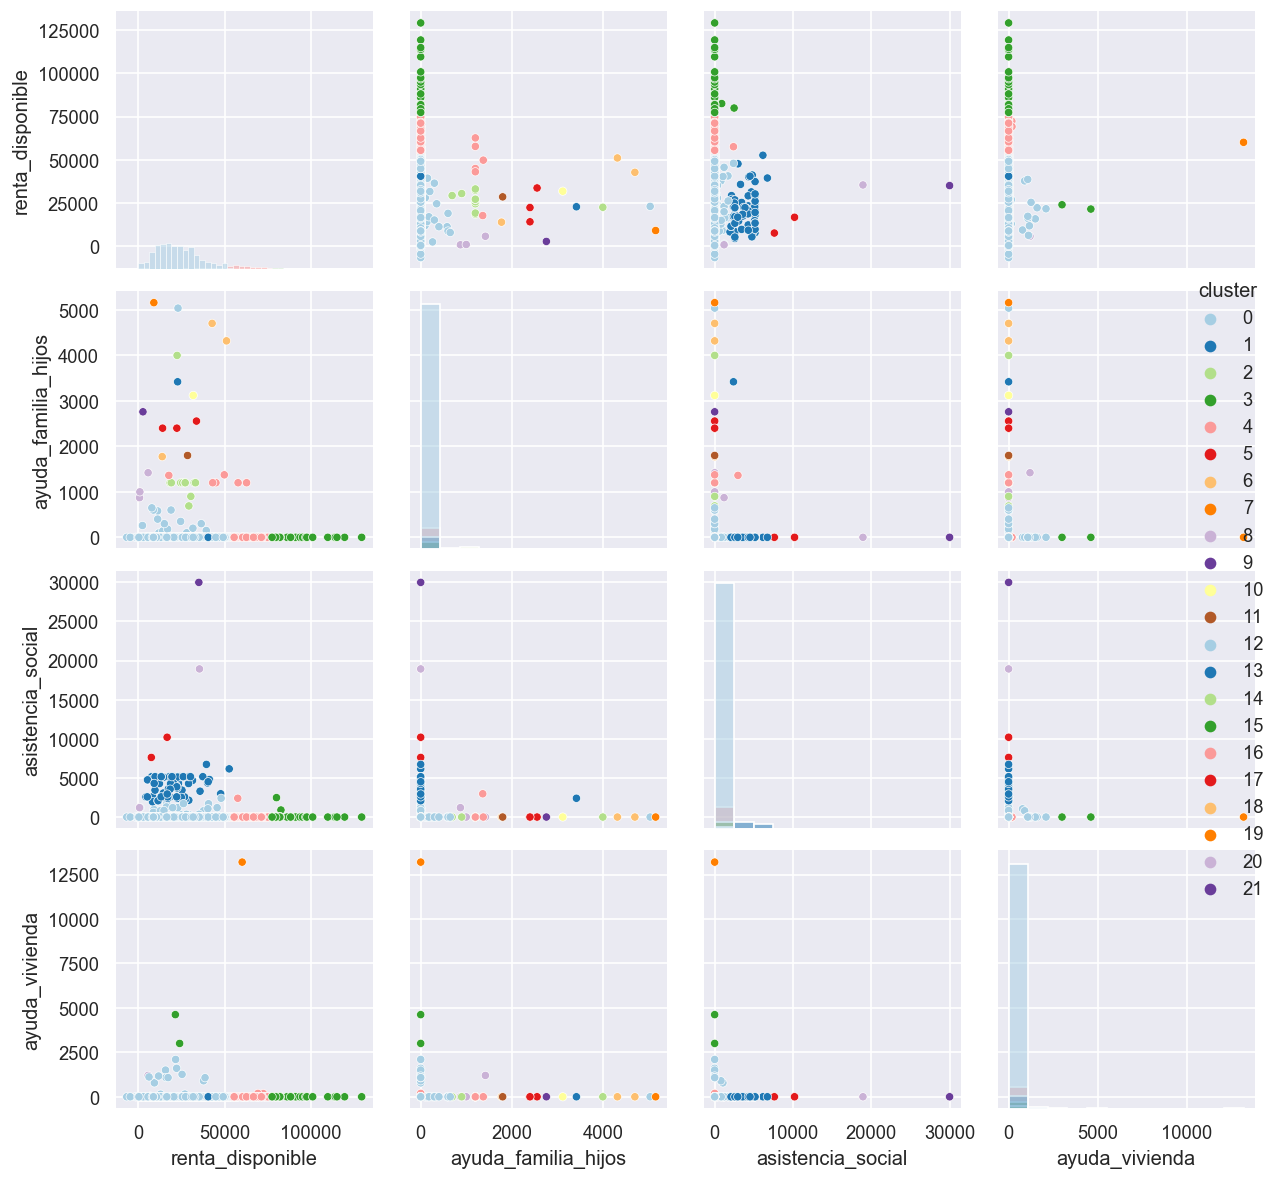

<Figure size 720x480 with 0 Axes>

In [27]:
visualization.plot_scatter_matrix(algorithms[3].instances[0])

##### Ward

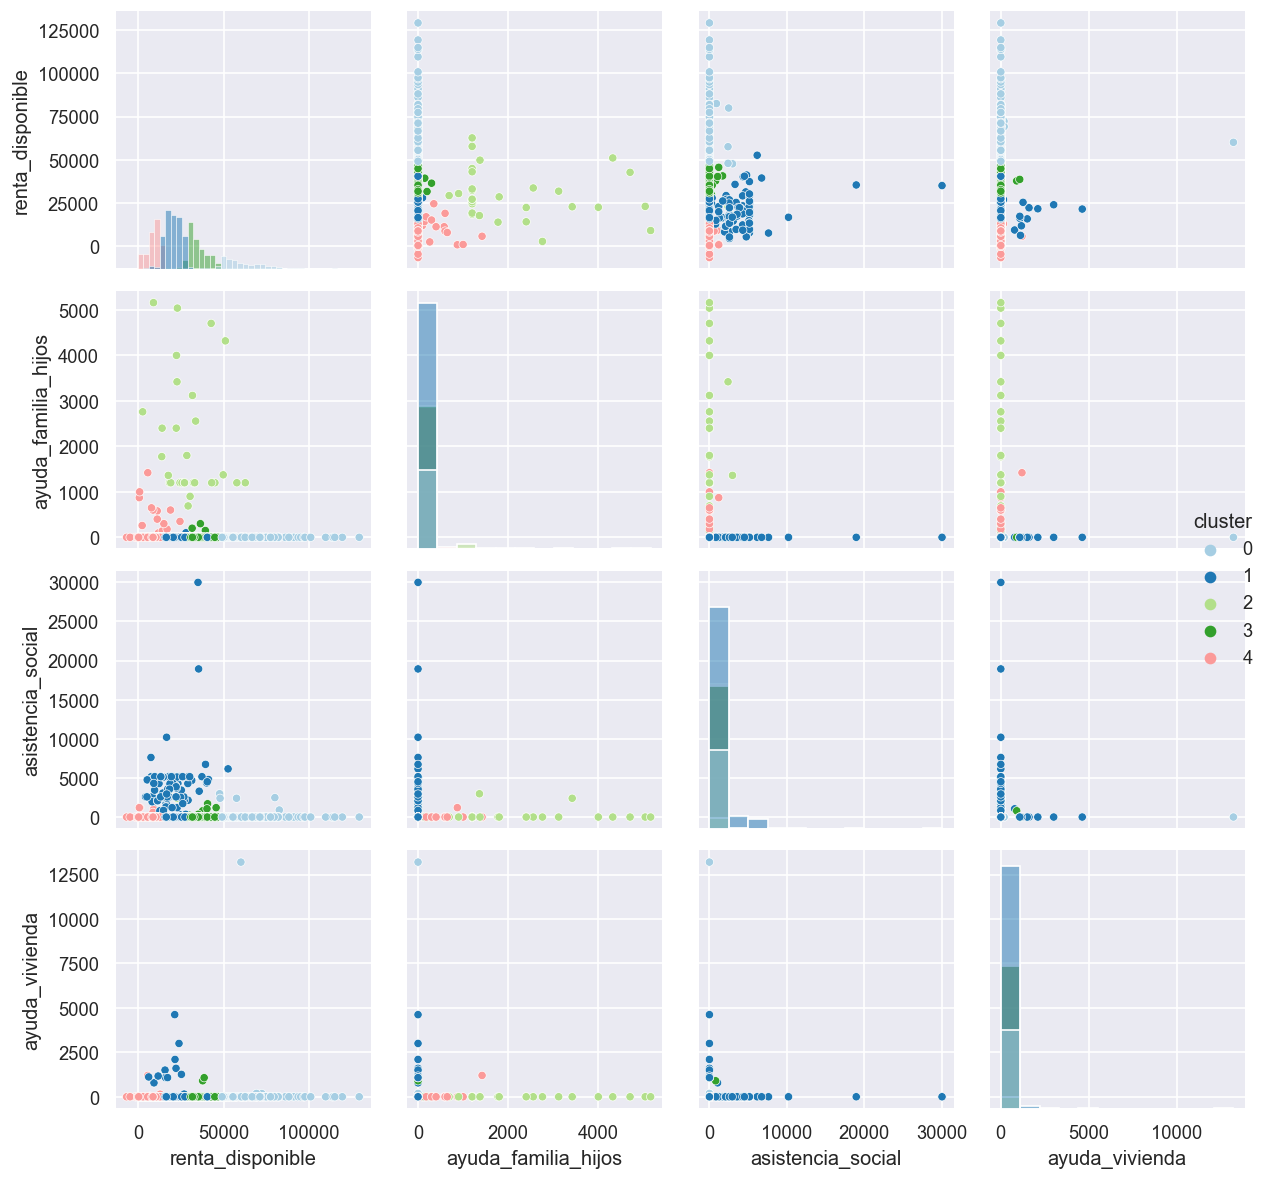

<Figure size 720x480 with 0 Axes>

In [28]:
visualization.plot_scatter_matrix(algorithms[4].instances[0])

#### Boxplot

##### K-Means

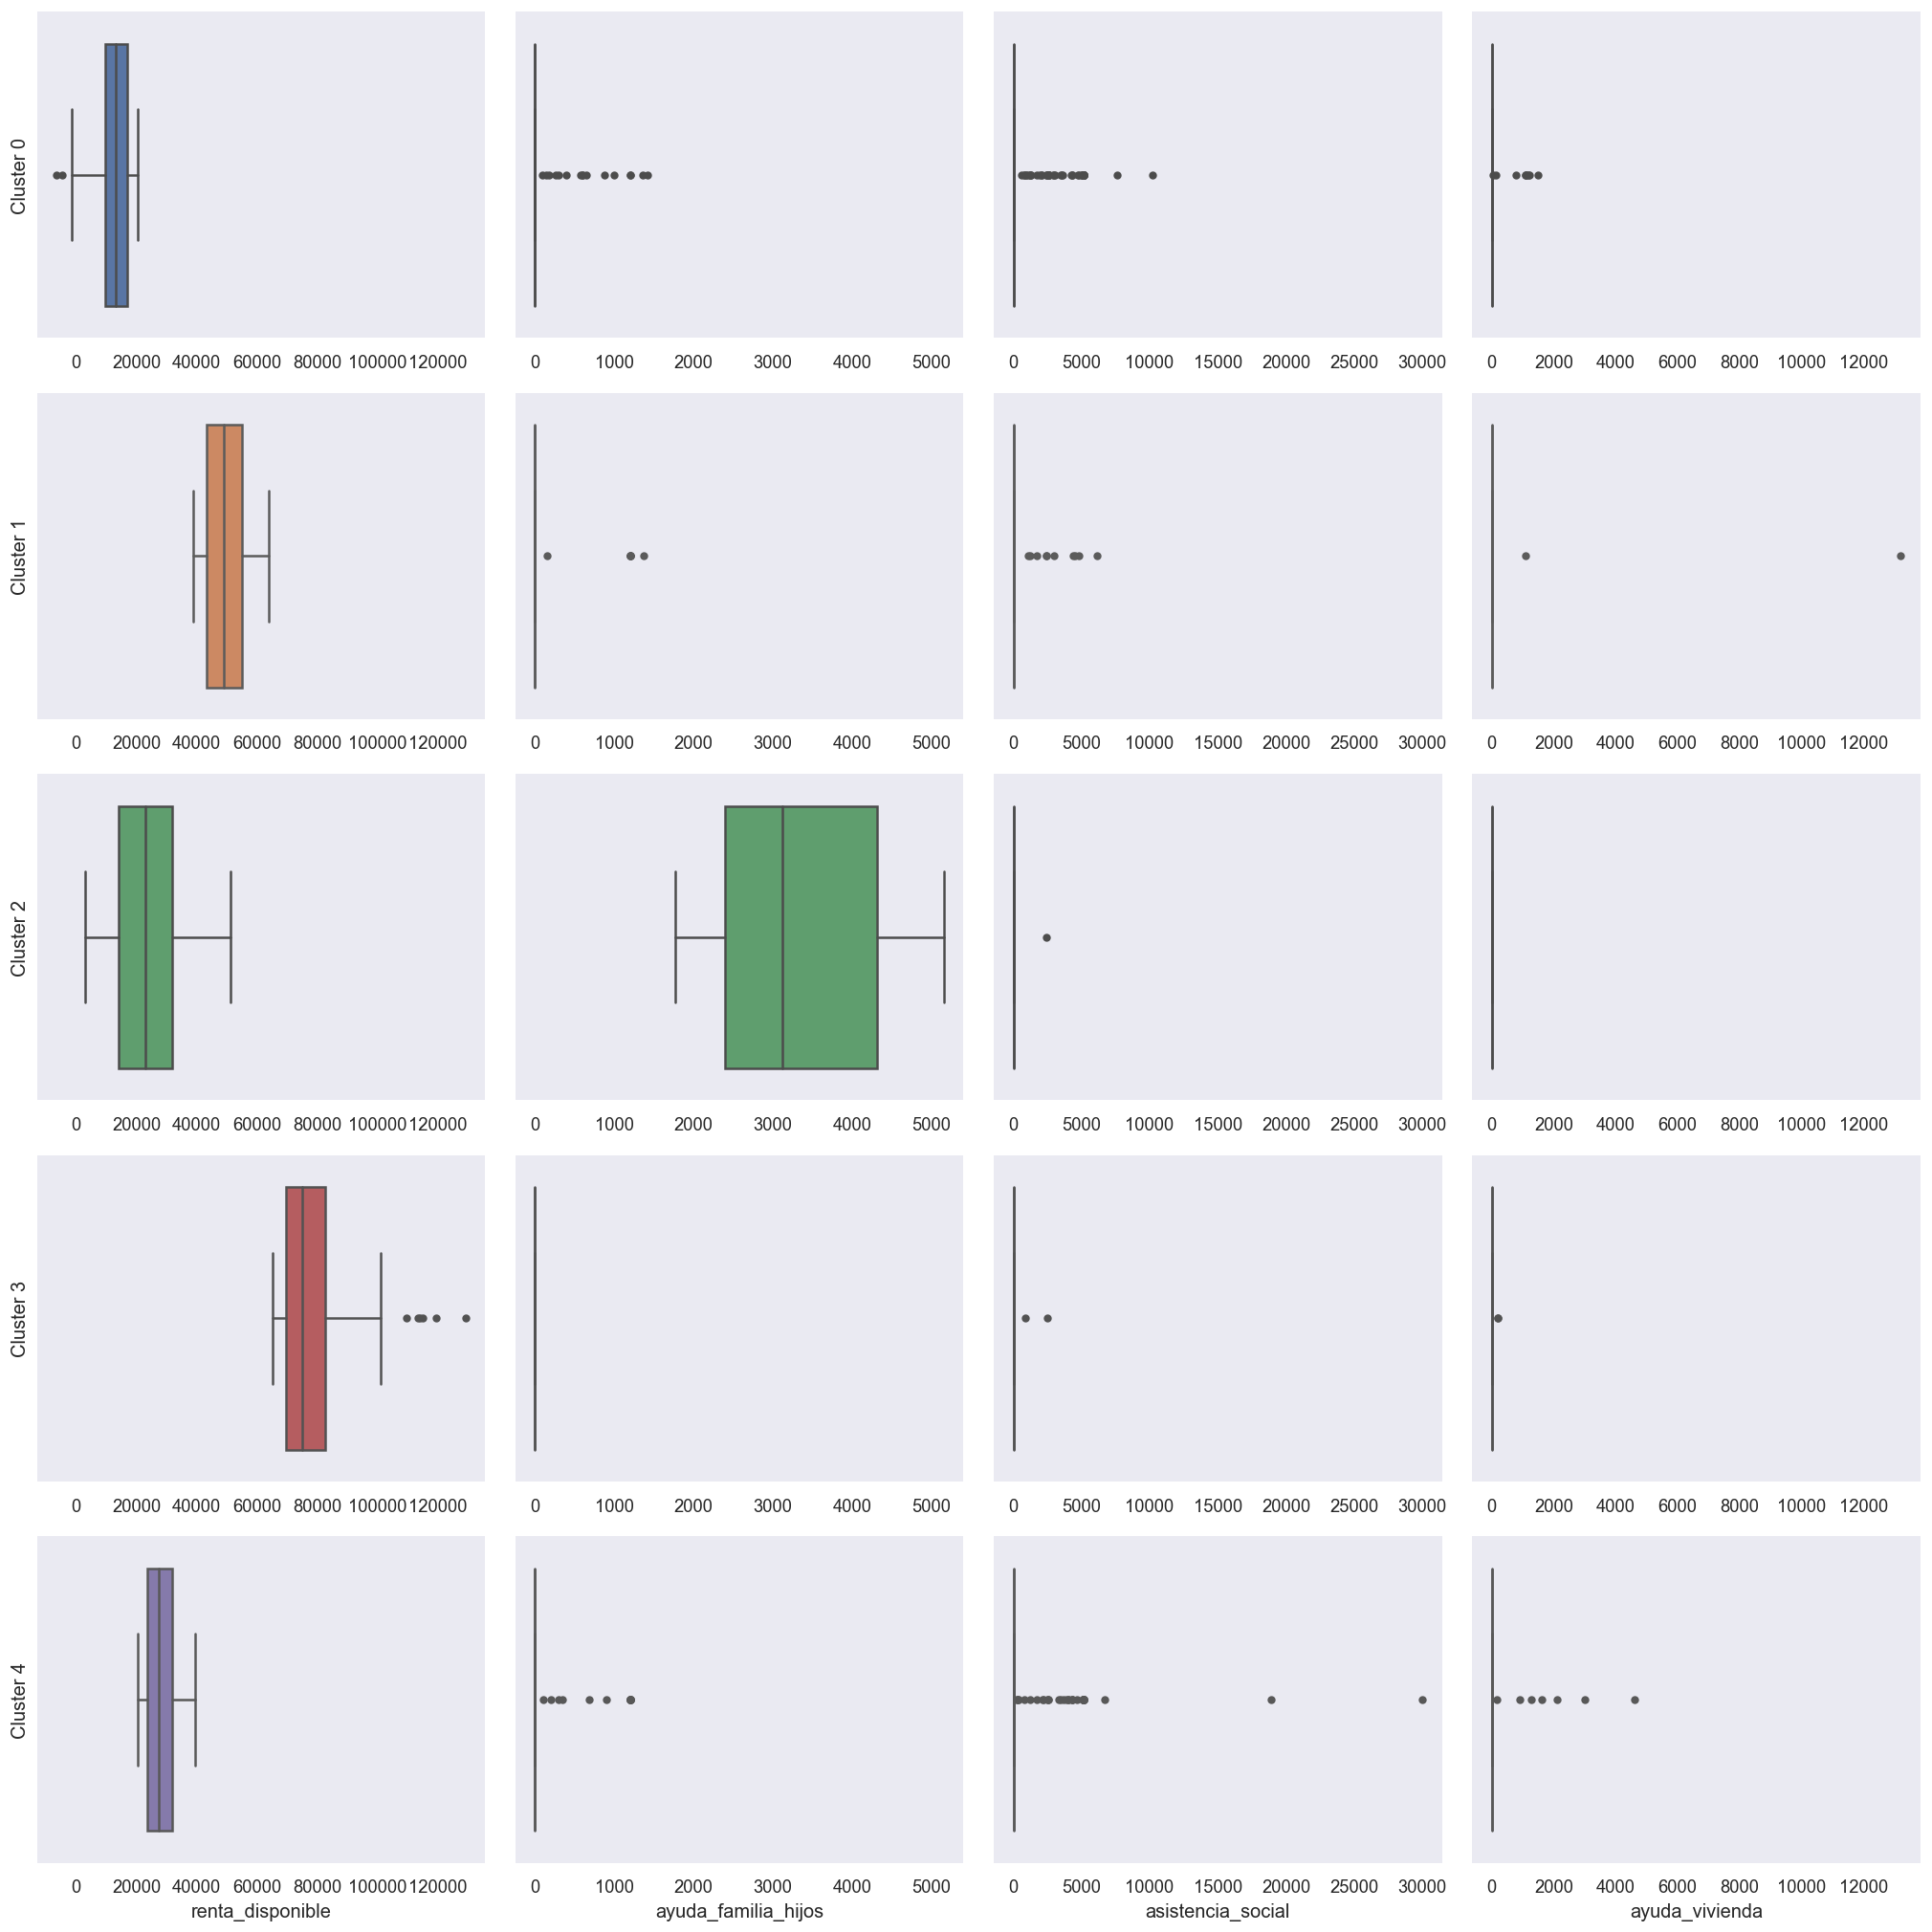

<Figure size 720x480 with 0 Axes>

In [29]:
visualization.plot_boxplot(algorithms[0].instances[0])

##### Birch

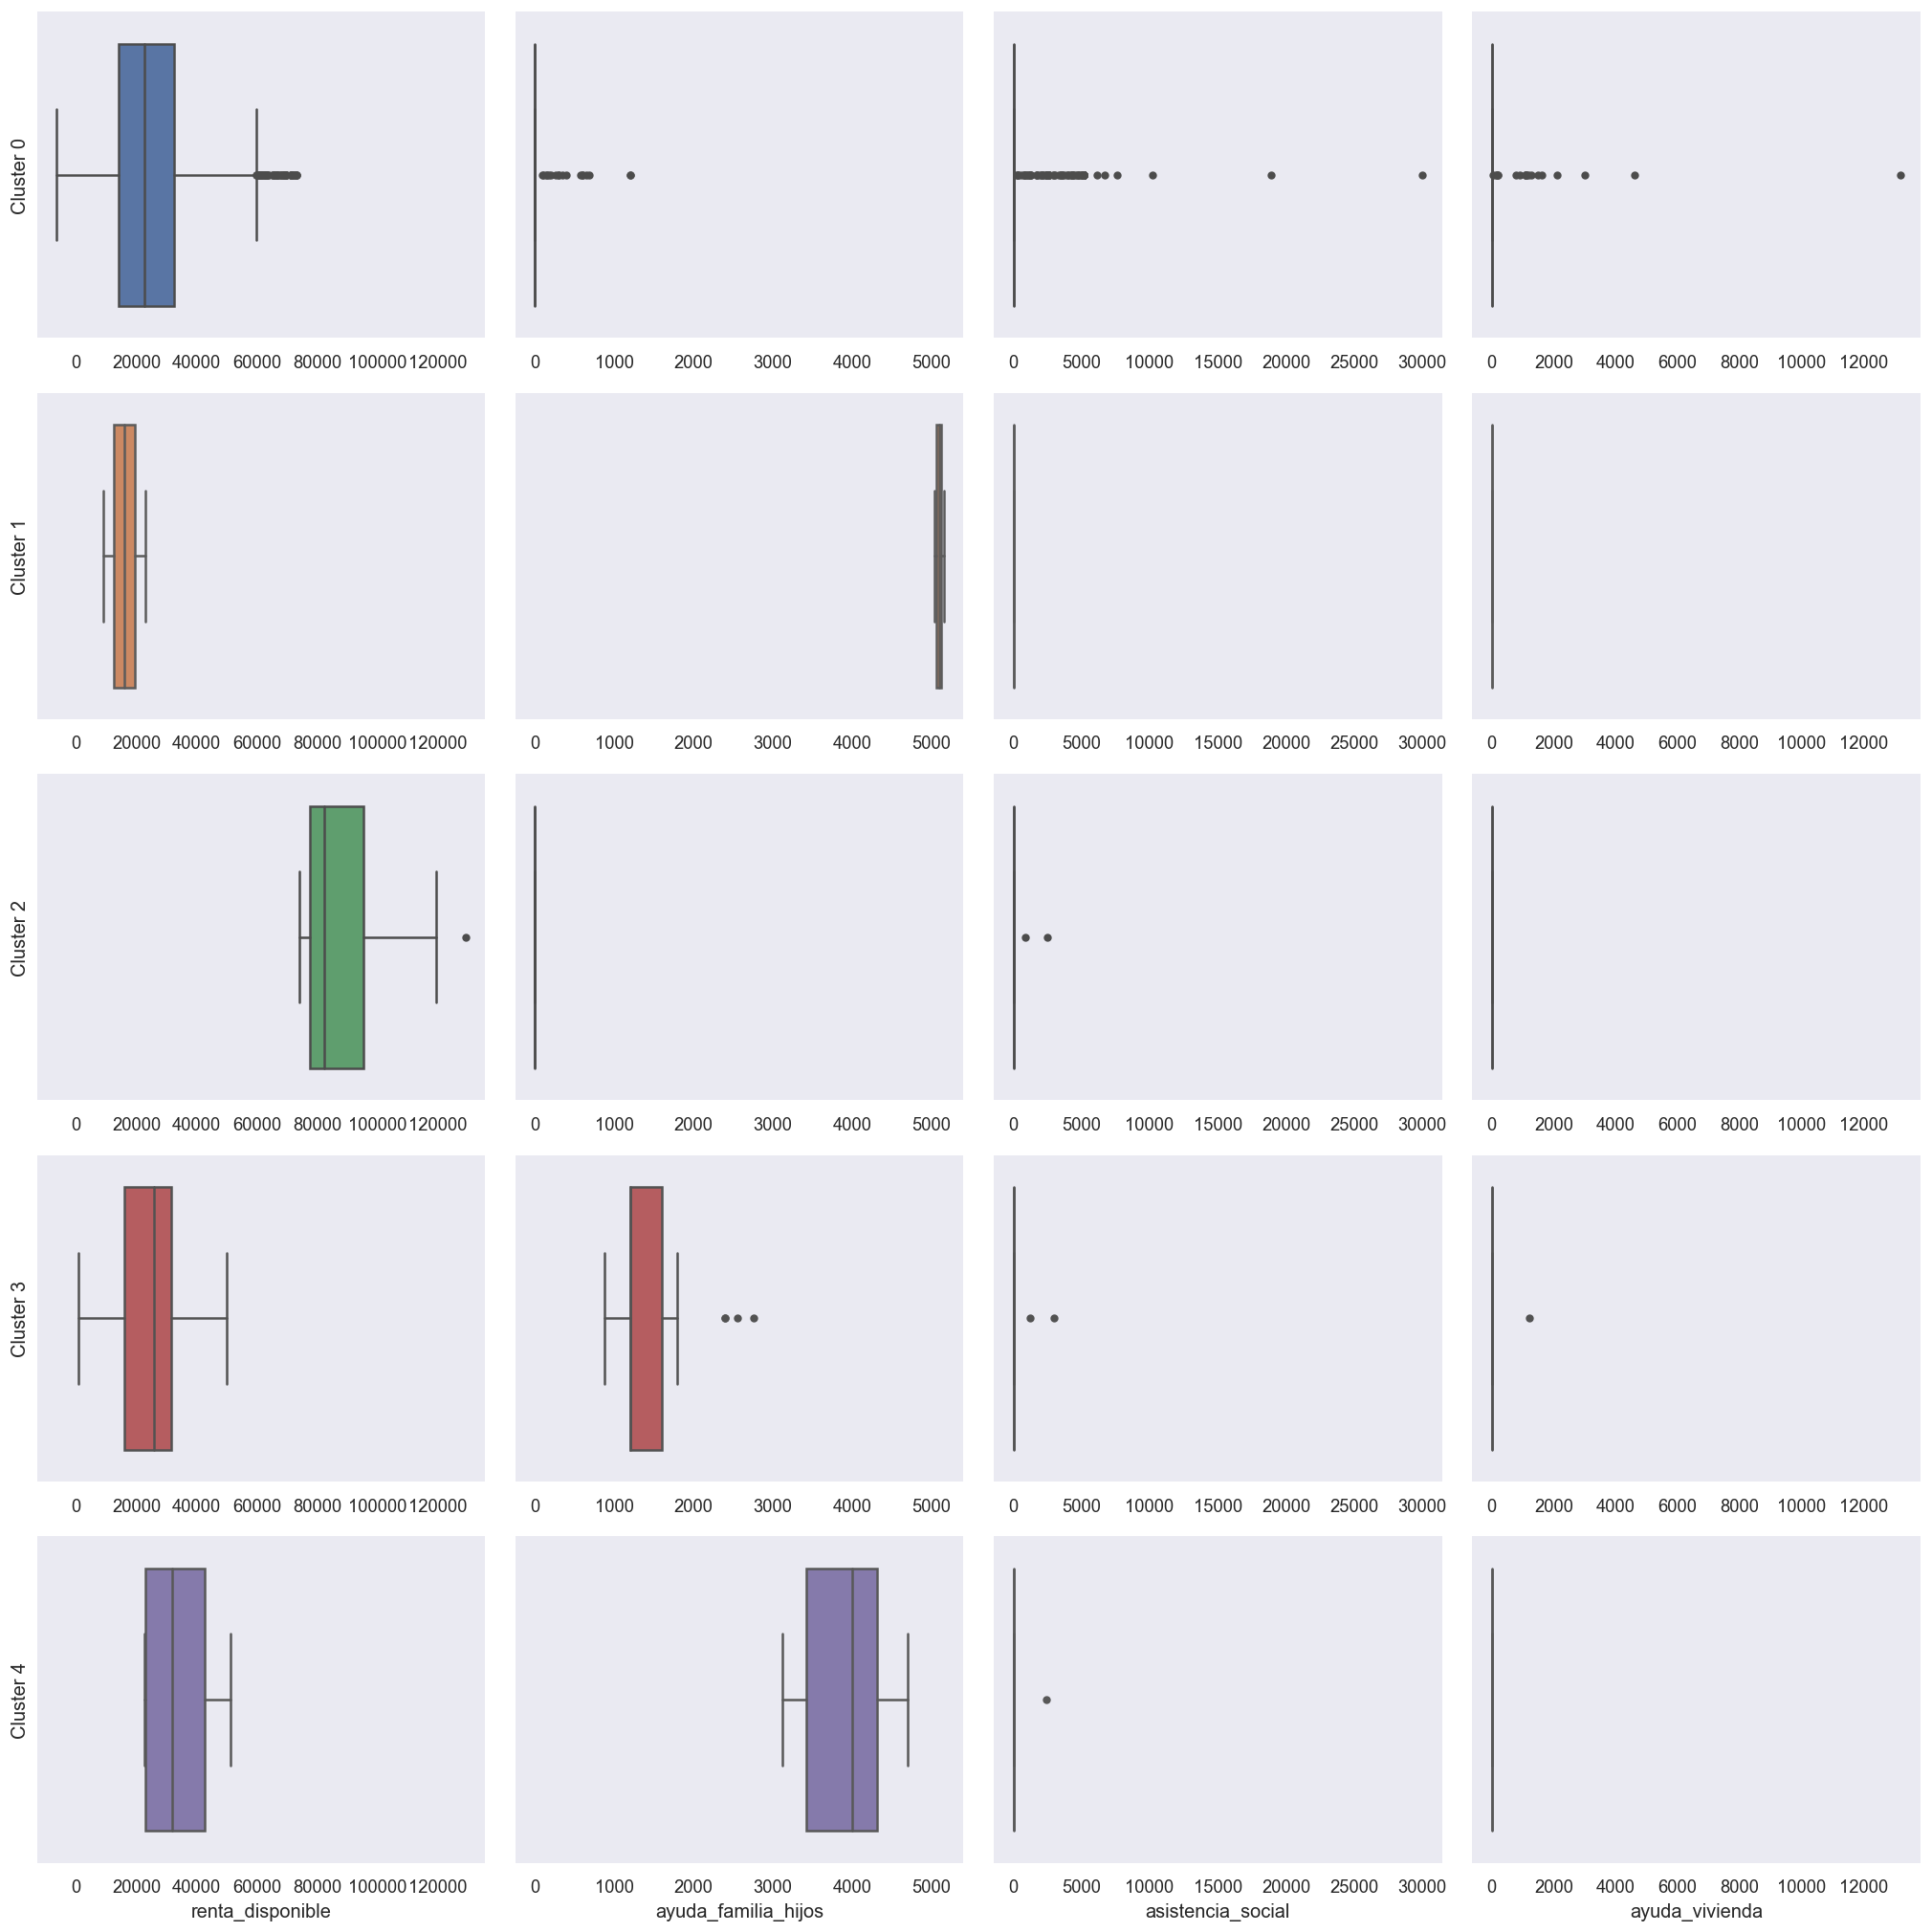

<Figure size 720x480 with 0 Axes>

In [30]:
visualization.plot_boxplot(algorithms[1].instances[0])

##### DBSCAN

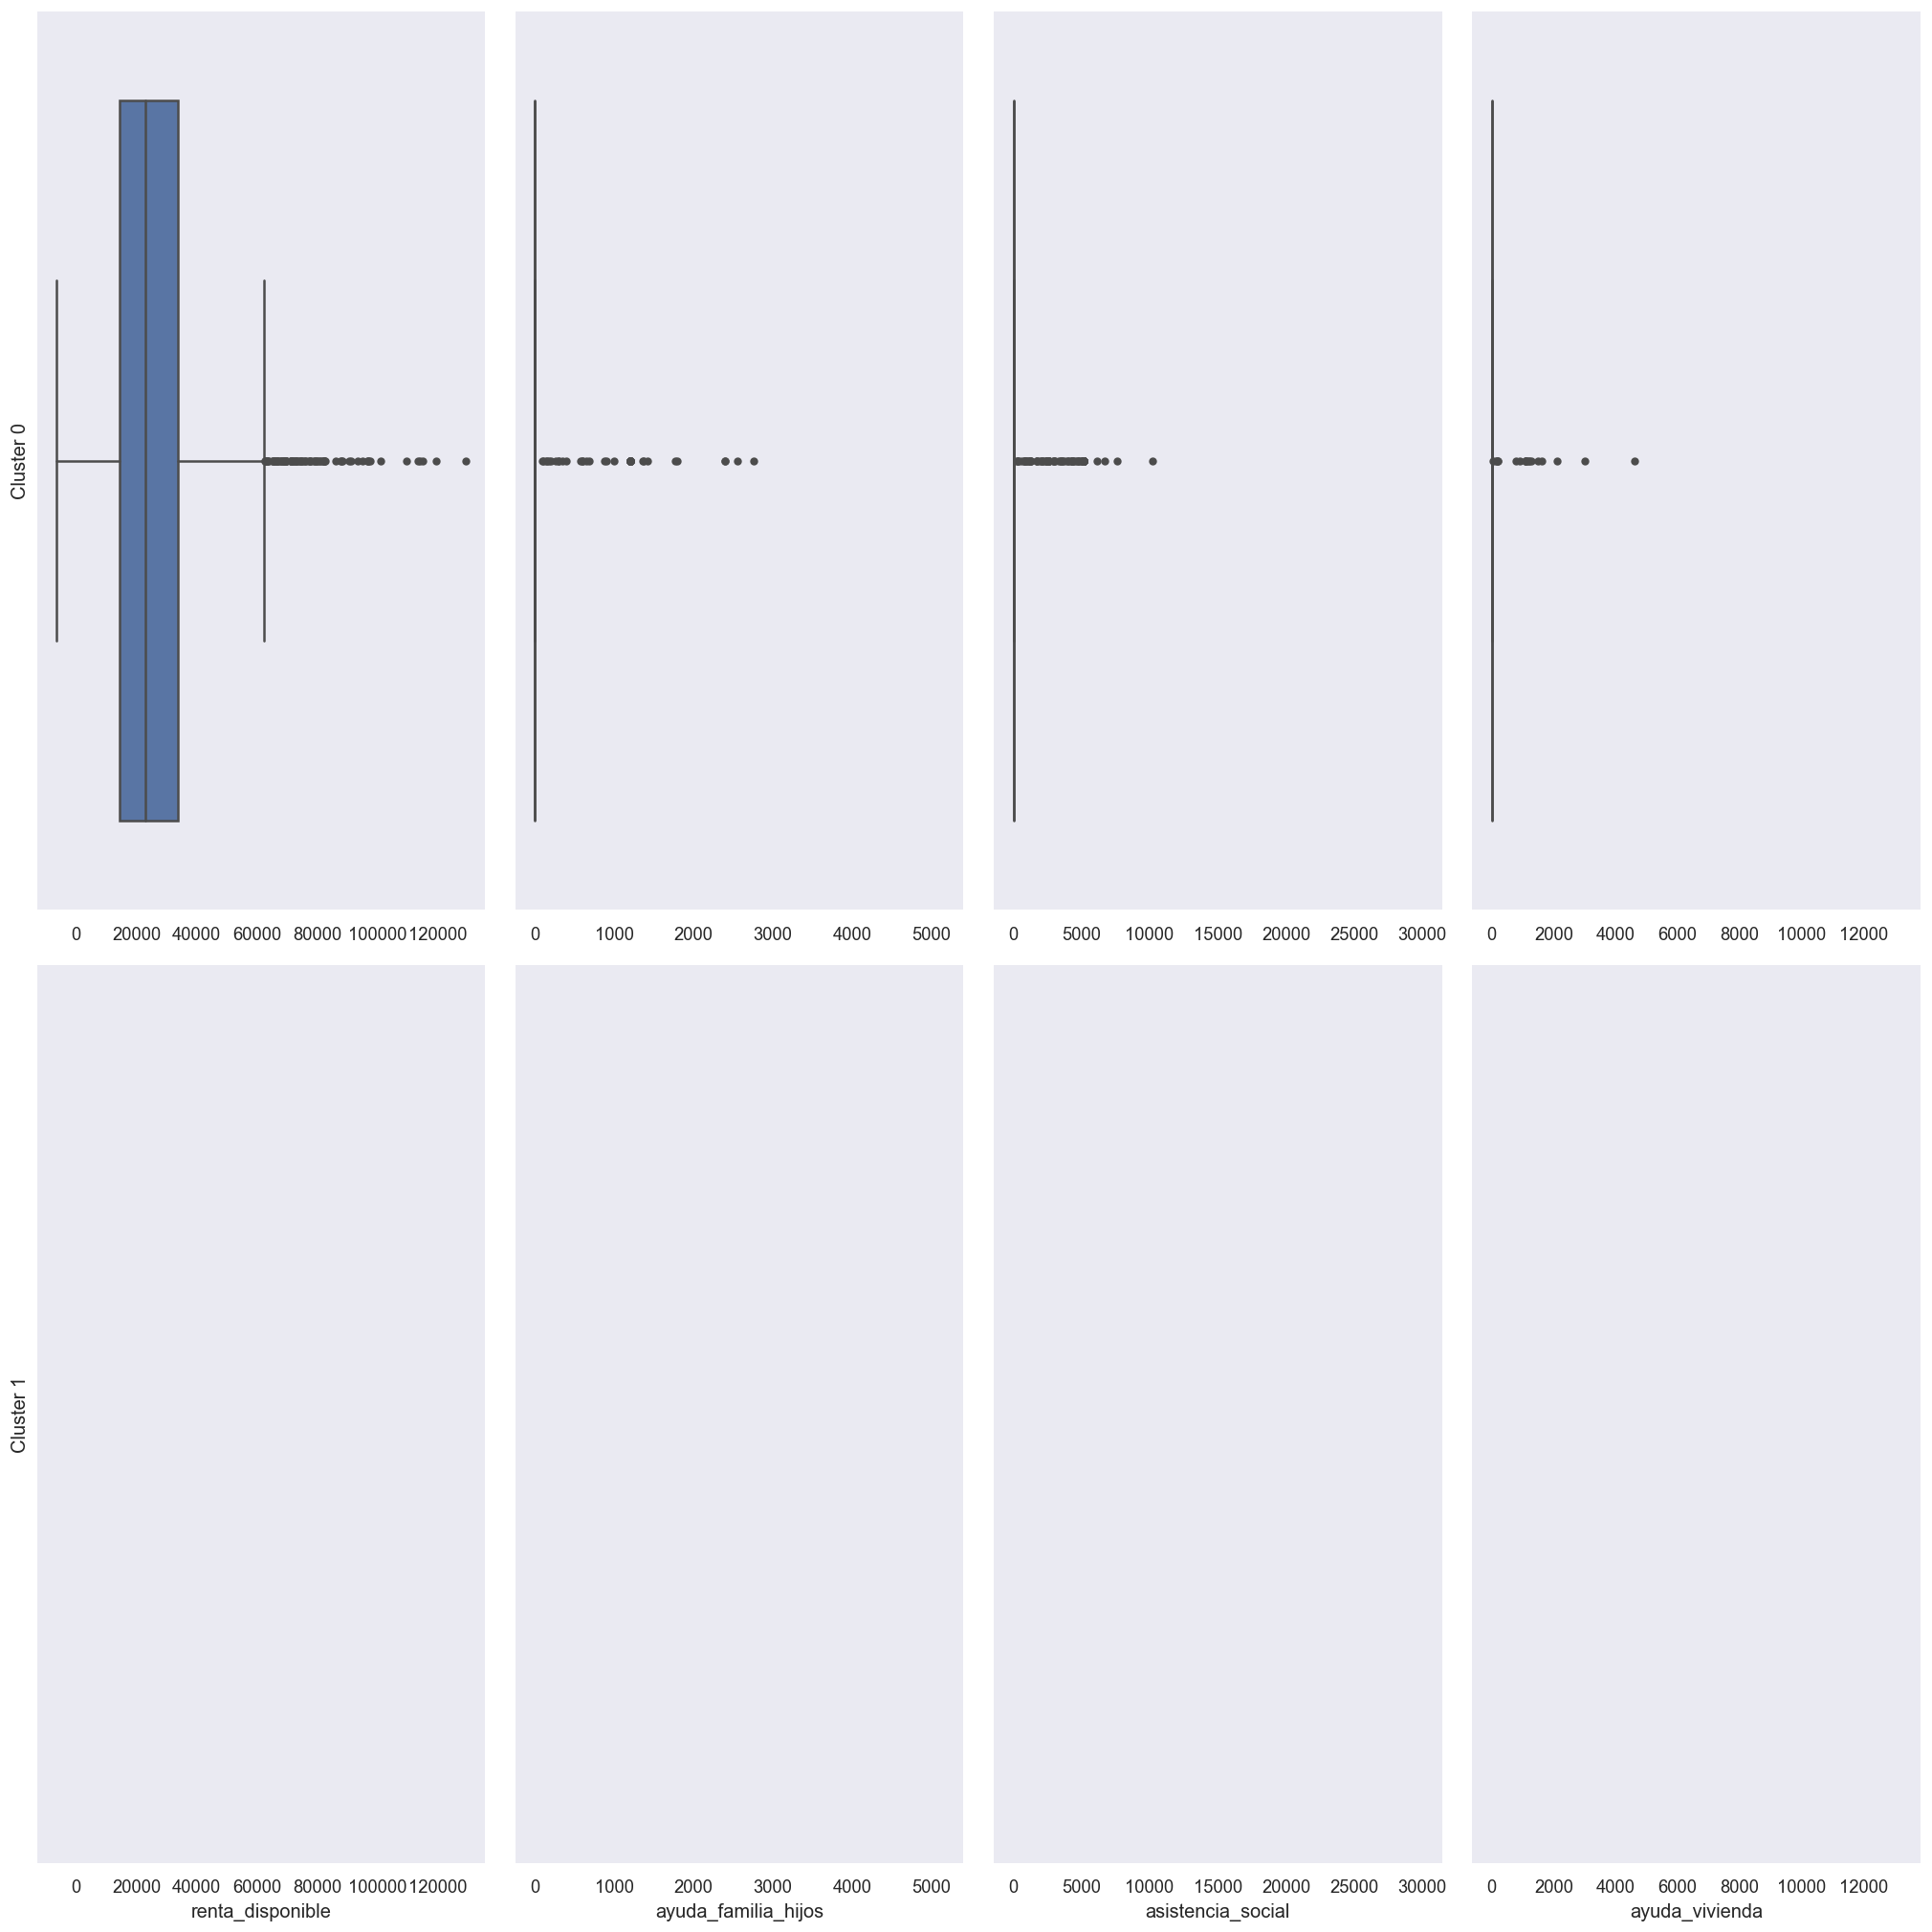

<Figure size 720x480 with 0 Axes>

In [31]:
visualization.plot_boxplot(algorithms[2].instances[0])

##### Mean Shift

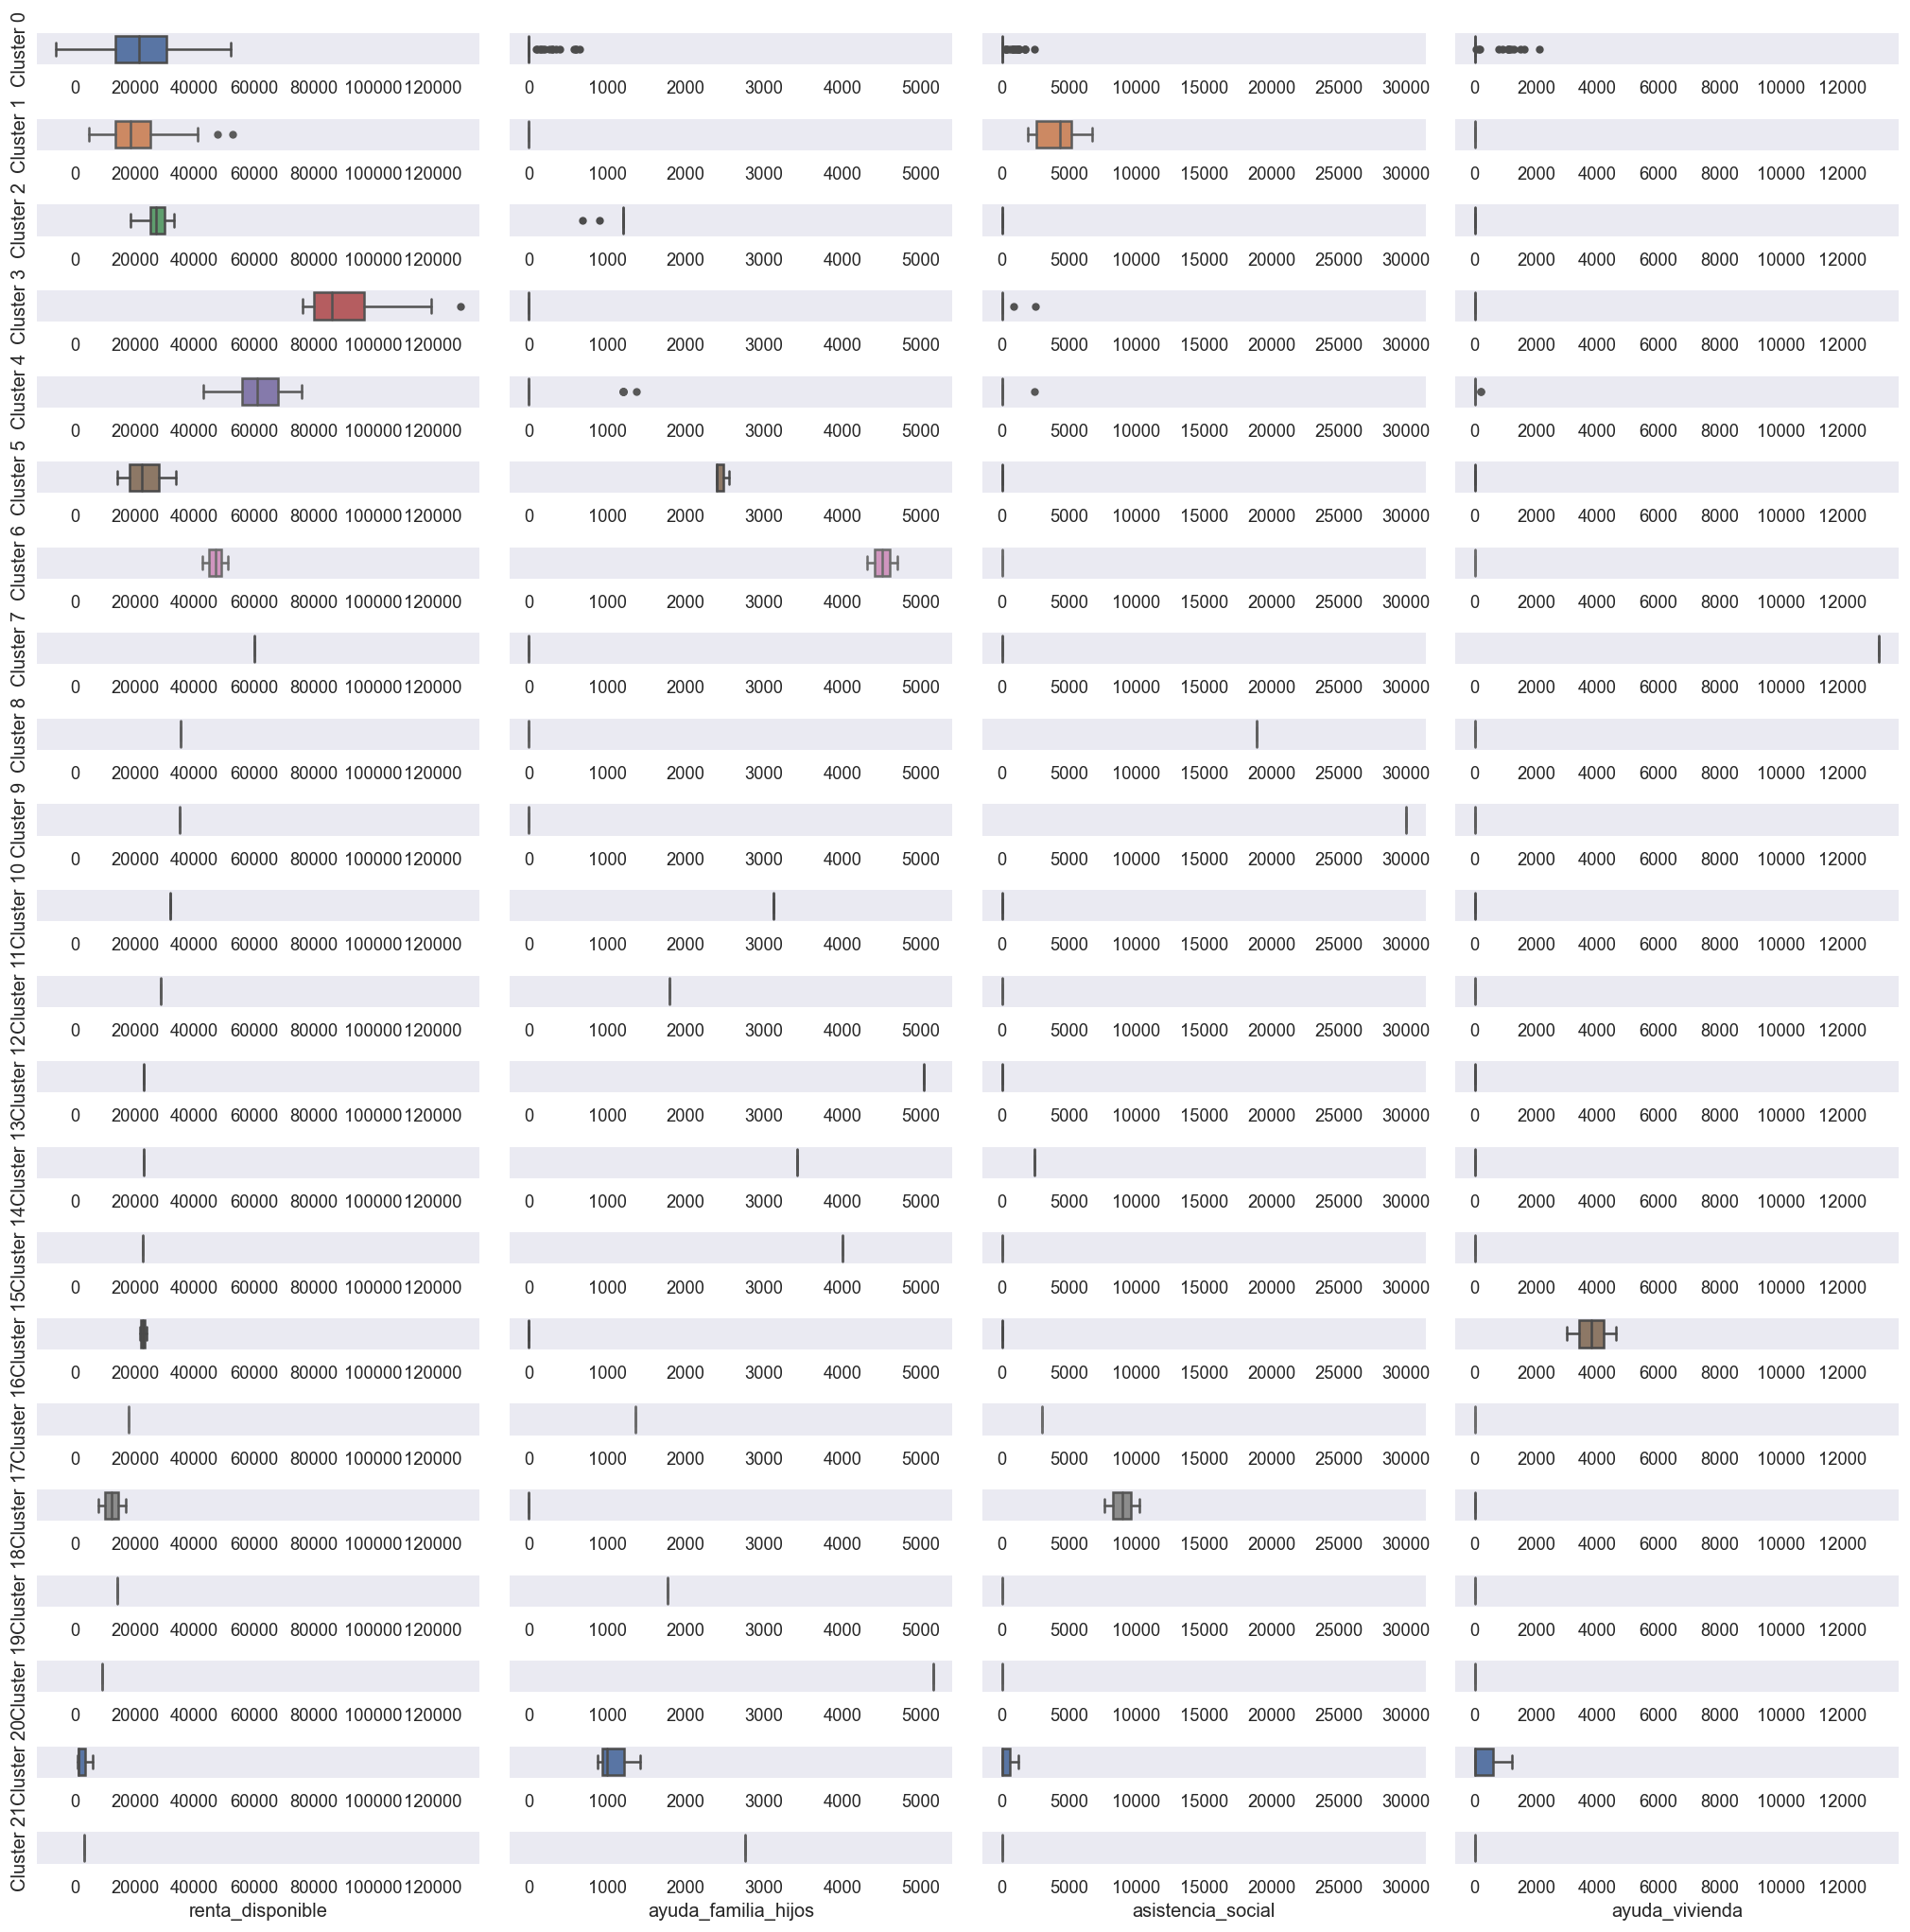

<Figure size 720x480 with 0 Axes>

In [32]:
visualization.plot_boxplot(algorithms[3].instances[0])

##### Ward

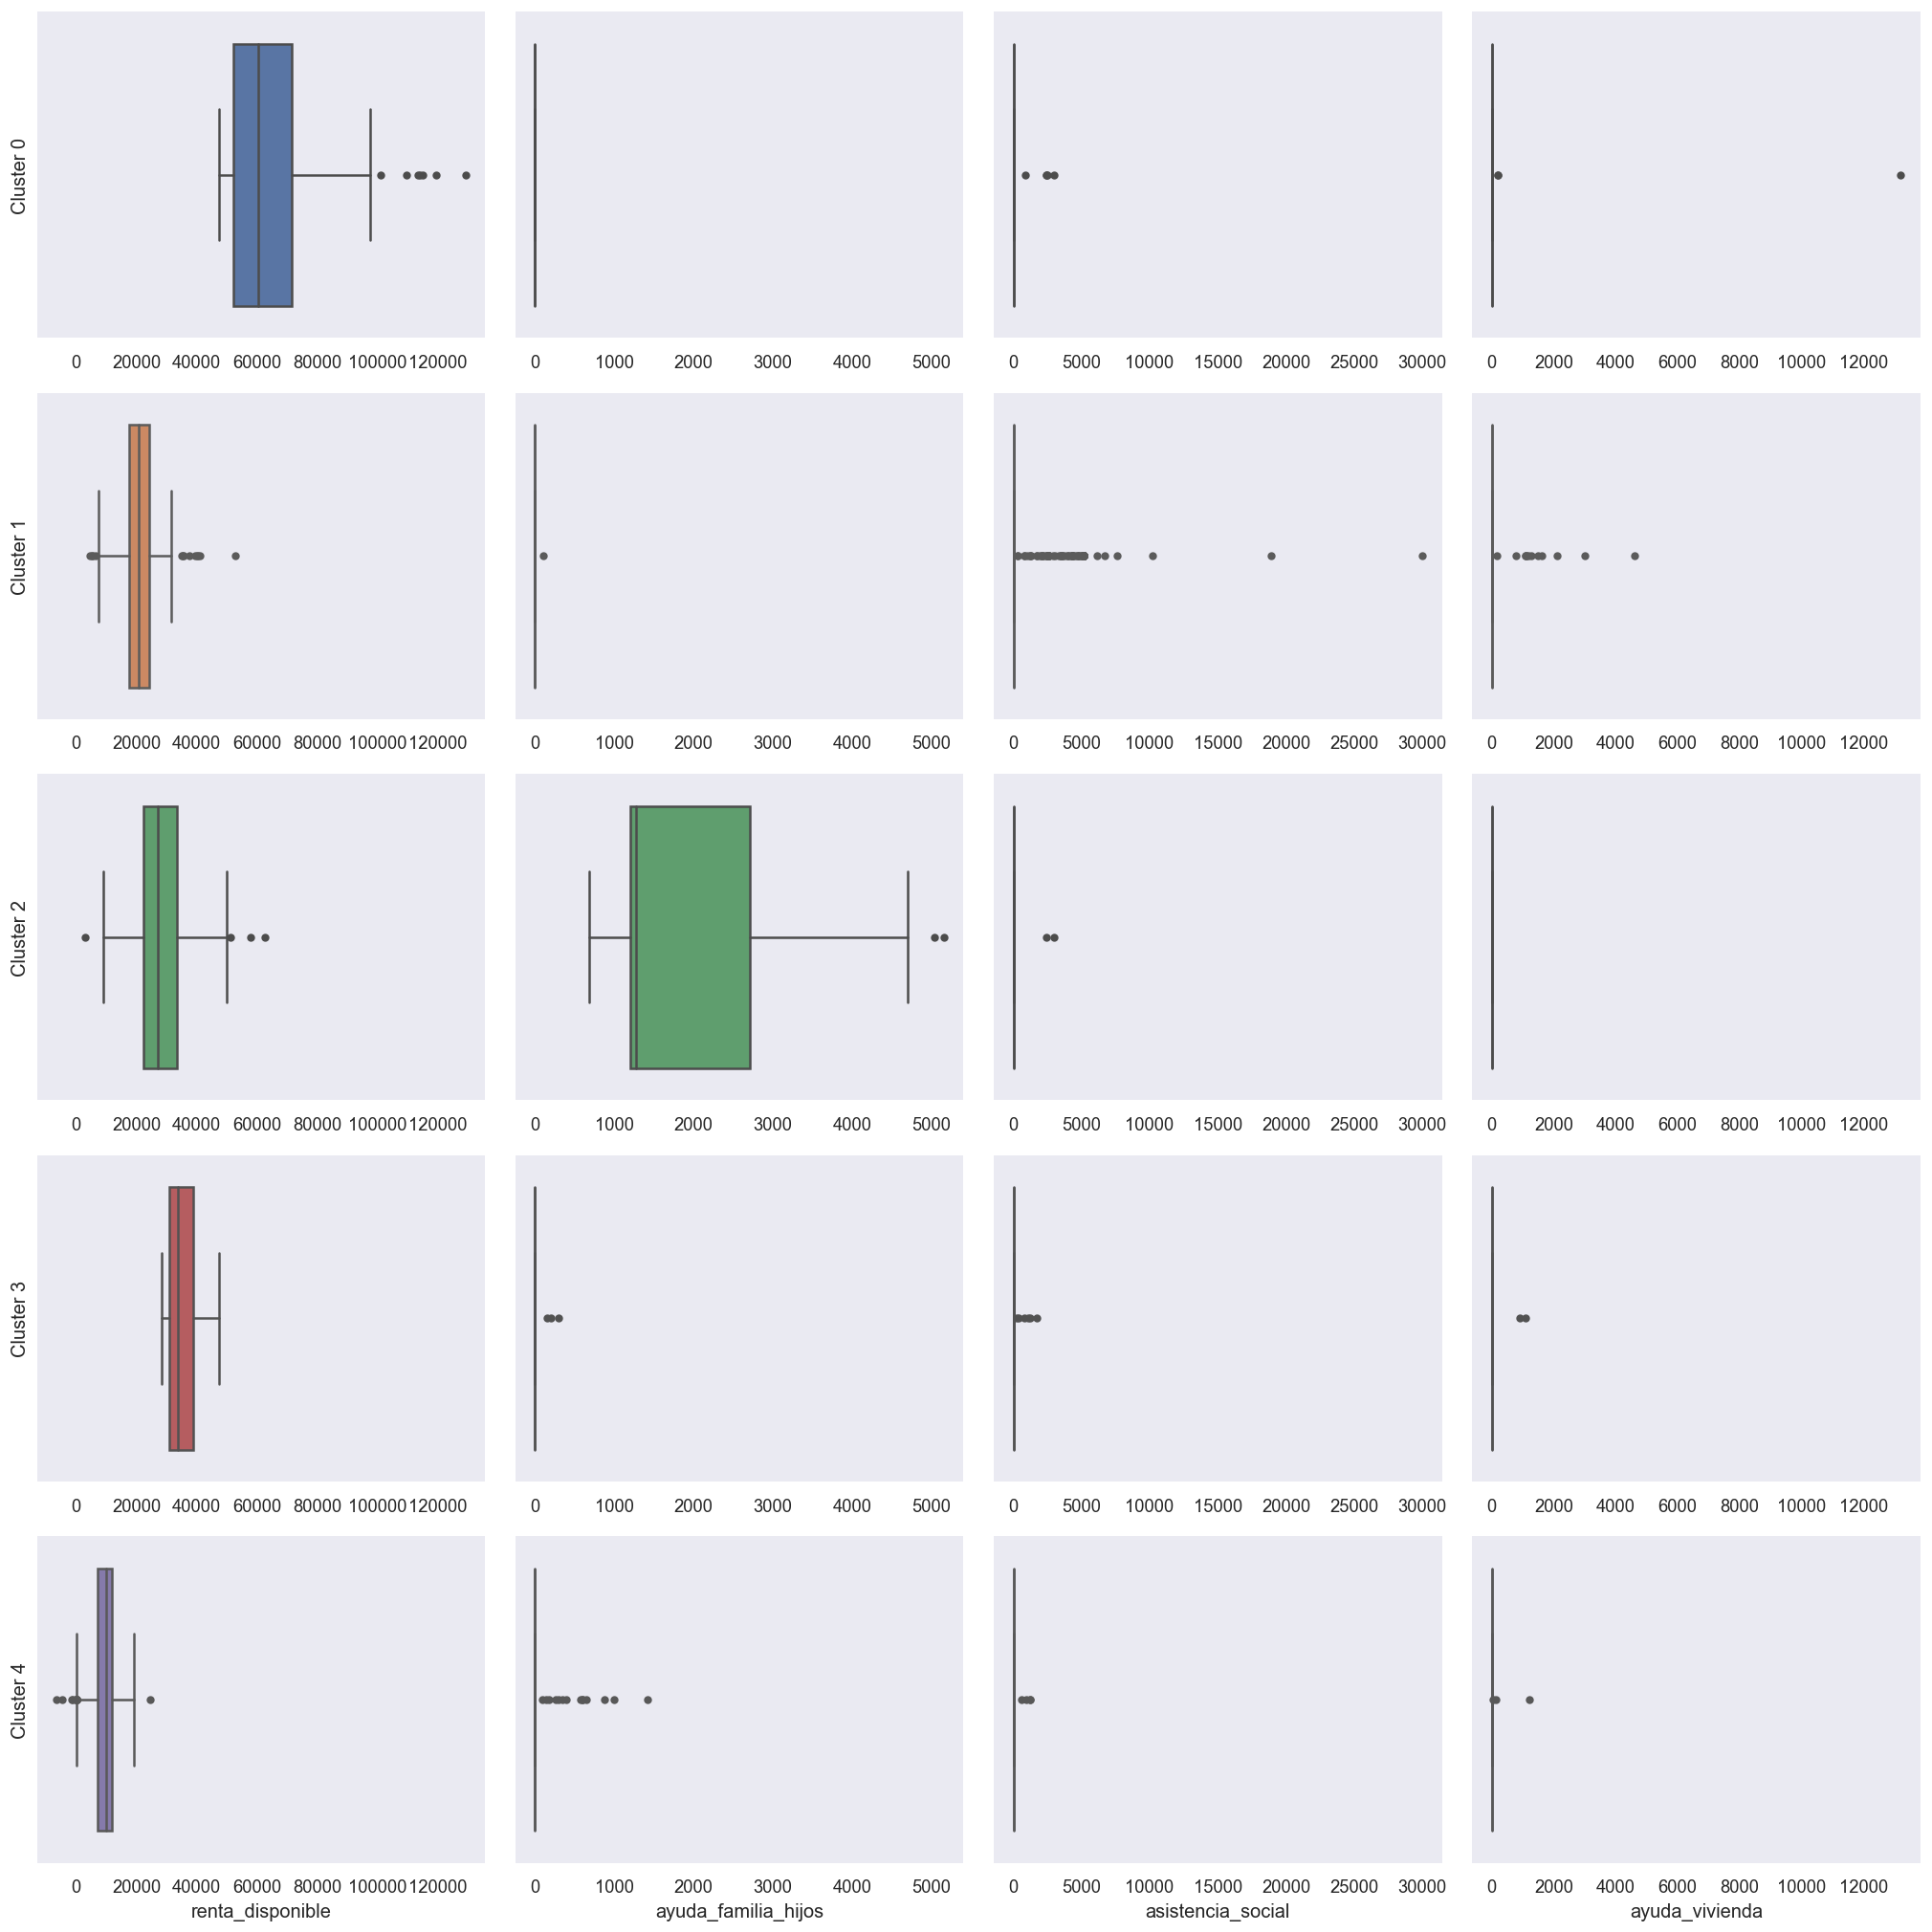

<Figure size 720x480 with 0 Axes>

In [33]:
visualization.plot_boxplot(algorithms[4].instances[0])

#### Dendrograma

##### Ward

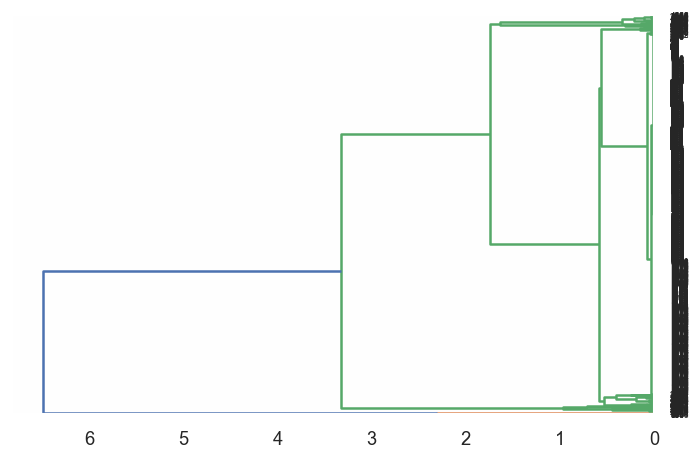

<Figure size 720x480 with 0 Axes>

In [35]:
visualization.plot_dendrogram(algorithms[4].instances[0])

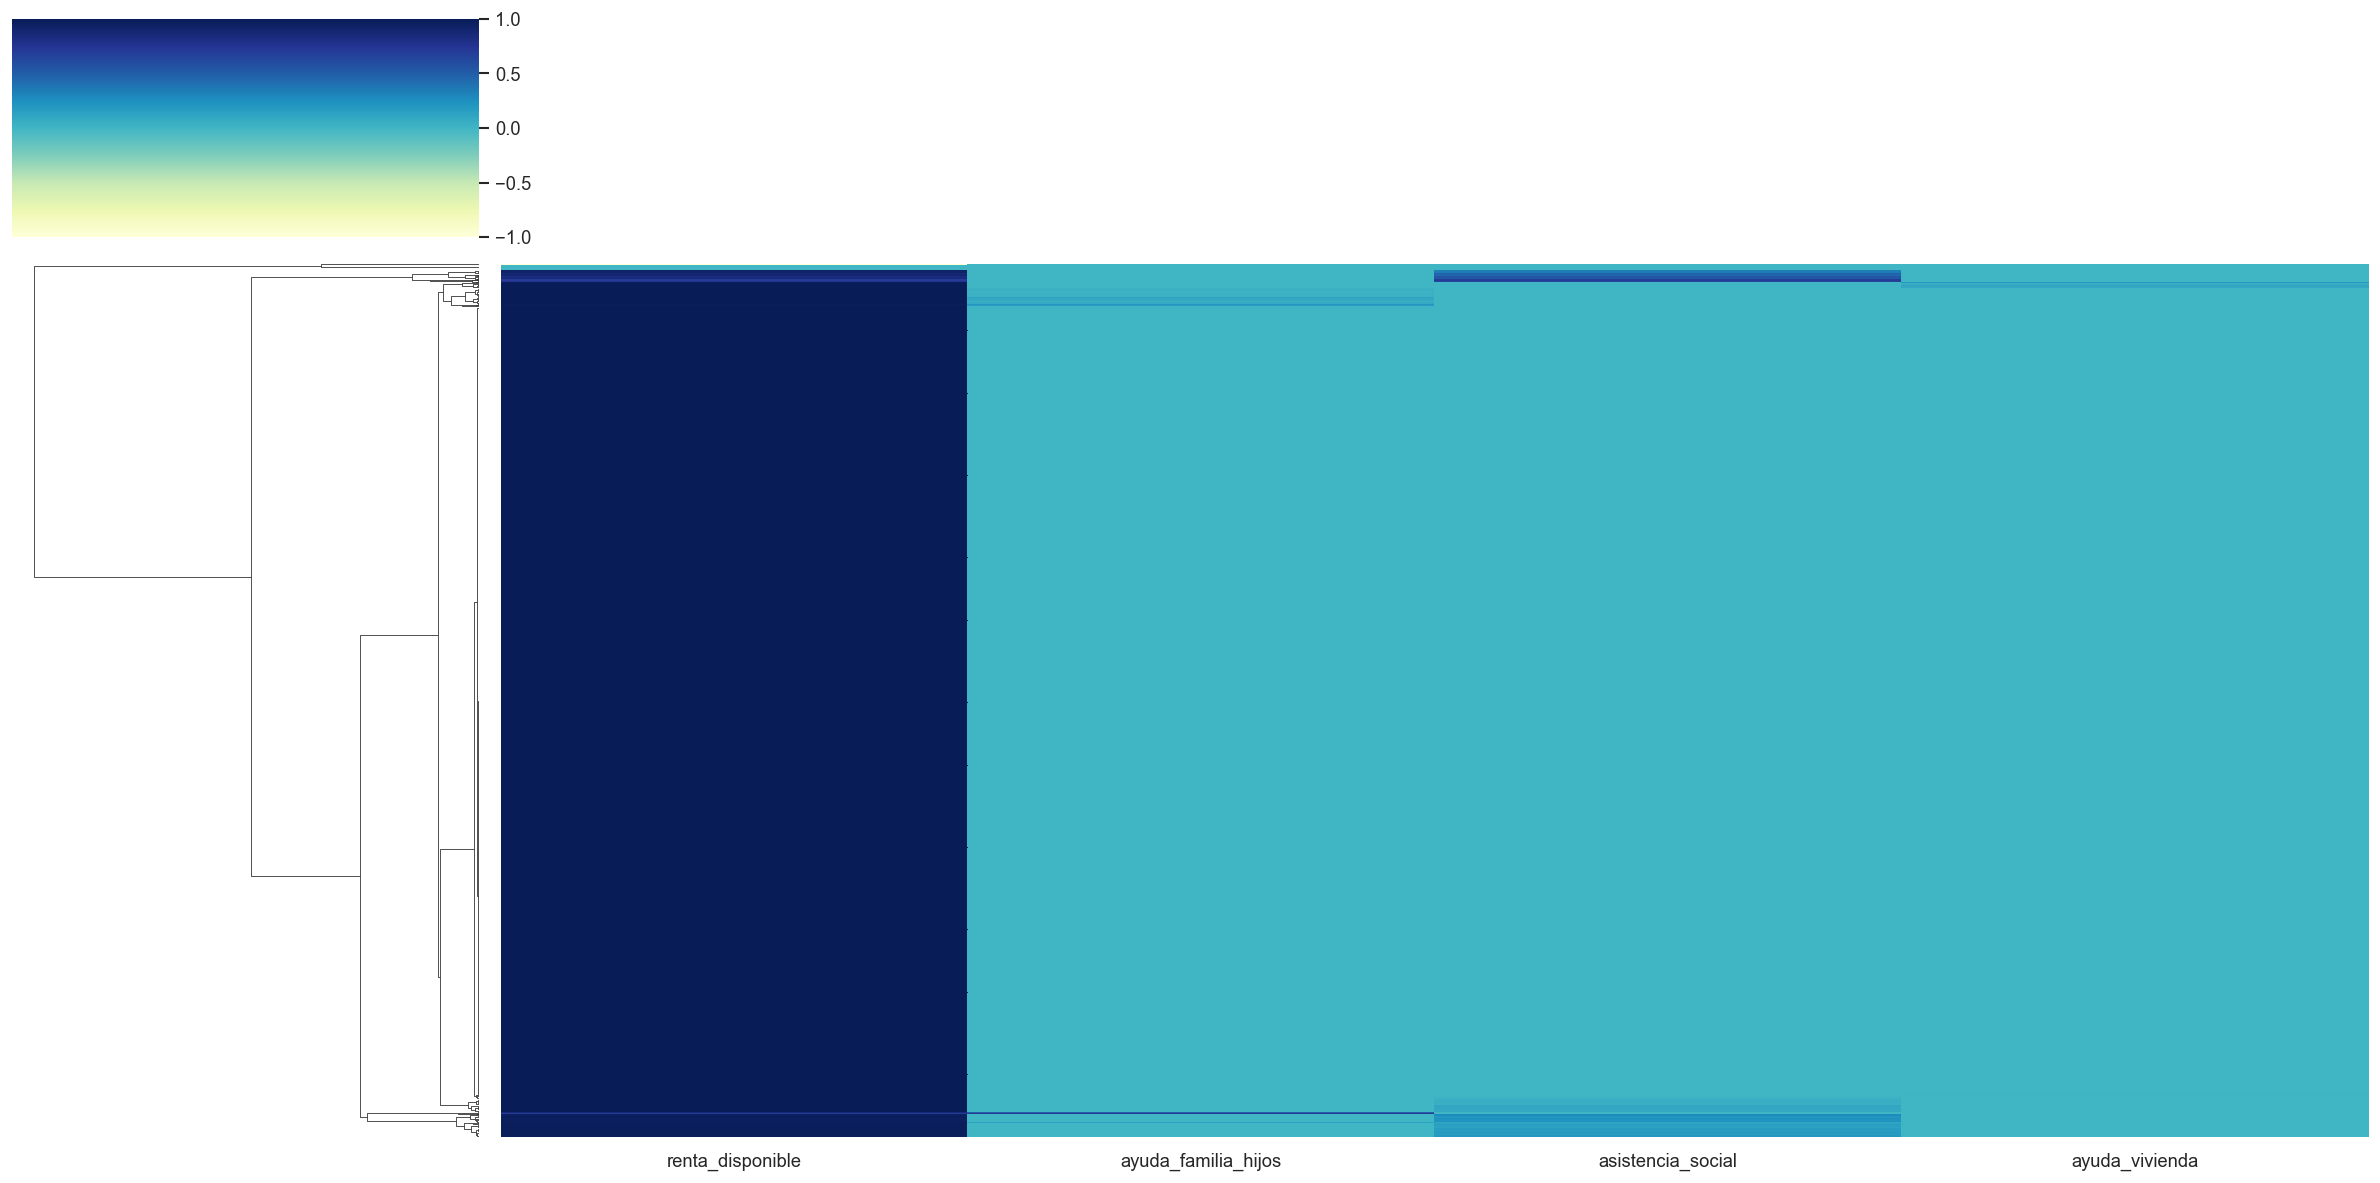

<Figure size 720x480 with 0 Axes>

In [36]:
visualization.plot_dendrogram_heat(algorithms[4].instances[0])

### Análisis K-Means

In [128]:
kmeans_ch = pd.DataFrame(columns=case.columns)
kmeans_X_clusters = algorithms[0].instances[0]['X_clusters']
for cluster in algorithms[0].instances[0]['cluster_ids']:
    quantiles = kmeans_X_clusters[kmeans_X_clusters['cluster']==cluster].quantile([.25, .75])
    d = {}
    for col in case.columns:
        d[col] = f"{quantiles.loc[.25][col]:.2f}-{quantiles.loc[.75][col]:.2f}"
    kmeans_ch.loc[cluster] = d
print(kmeans_ch.to_latex())

\begin{tabular}{lllll}
\toprule
{} &   renta\_disponible & ayuda\_familia\_hijos & asistencia\_social & ayuda\_vivienda \\
\midrule
0 &   9458.05-16916.11 &           0.00-0.00 &         0.00-0.00 &      0.00-0.00 \\
1 &  43180.67-55023.05 &           0.00-0.00 &         0.00-0.00 &      0.00-0.00 \\
2 &  14132.70-31845.70 &     2400.00-4320.00 &         0.00-0.00 &      0.00-0.00 \\
3 &  69605.30-82486.25 &           0.00-0.00 &         0.00-0.00 &      0.00-0.00 \\
4 &  23686.33-31690.17 &           0.00-0.00 &         0.00-0.00 &      0.00-0.00 \\
\bottomrule
\end{tabular}



In [39]:
kmeans = ClusterAlgorithm(KMeans, name='K-Means', centroid_attr='cluster_centers_', not_instantiate=True)

In [40]:
kmeans.add_instances_product({
    'init': ['k-means++'],
    'n_clusters': range(2, 20),
    'n_init': [5],
    'random_state': [common.RANDOM_SEED],
})

['k-means++'] range(2, 20) [5] [19122000]


In [41]:
kmeans

<ClusterAlgorithm [K-Means], 18 instances:
	init=k-means++, n_clusters=2, n_init=5, random_state=19122000;
	init=k-means++, n_clusters=3, n_init=5, random_state=19122000;
	init=k-means++, n_clusters=4, n_init=5, random_state=19122000;
	init=k-means++, n_clusters=5, n_init=5, random_state=19122000;
	init=k-means++, n_clusters=6, n_init=5, random_state=19122000;
	init=k-means++, n_clusters=7, n_init=5, random_state=19122000;
	init=k-means++, n_clusters=8, n_init=5, random_state=19122000;
	init=k-means++, n_clusters=9, n_init=5, random_state=19122000;
	init=k-means++, n_clusters=10, n_init=5, random_state=19122000;
	init=k-means++, n_clusters=11, n_init=5, random_state=19122000;
	init=k-means++, n_clusters=12, n_init=5, random_state=19122000;
	init=k-means++, n_clusters=13, n_init=5, random_state=19122000;
	init=k-means++, n_clusters=14, n_init=5, random_state=19122000;
	init=k-means++, n_clusters=15, n_init=5, random_state=19122000;
	init=k-means++, n_clusters=16, n_init=5, random_state=

In [43]:
kmeans.run_instances(case, verbose=True)

[K-Means] Running instance init=k-means++, n_clusters=2, n_init=5, random_state=19122000...
[K-Means] Running instance init=k-means++, n_clusters=3, n_init=5, random_state=19122000...
[K-Means] Running instance init=k-means++, n_clusters=4, n_init=5, random_state=19122000...
[K-Means] Running instance init=k-means++, n_clusters=5, n_init=5, random_state=19122000...
[K-Means] Running instance init=k-means++, n_clusters=6, n_init=5, random_state=19122000...
[K-Means] Running instance init=k-means++, n_clusters=7, n_init=5, random_state=19122000...
[K-Means] Running instance init=k-means++, n_clusters=8, n_init=5, random_state=19122000...
[K-Means] Running instance init=k-means++, n_clusters=9, n_init=5, random_state=19122000...
[K-Means] Running instance init=k-means++, n_clusters=10, n_init=5, random_state=19122000...
[K-Means] Running instance init=k-means++, n_clusters=11, n_init=5, random_state=19122000...
[K-Means] Running instance init=k-means++, n_clusters=12, n_init=5, random_sta

In [46]:
kmeans.calculate_metrics(cluster.metrics, verbose=True)

[K-Means] Calculating metrics in instance init=k-means++, n_clusters=2, n_init=5, random_state=19122000...
[K-Means] Calculating metrics in instance init=k-means++, n_clusters=3, n_init=5, random_state=19122000...
[K-Means] Calculating metrics in instance init=k-means++, n_clusters=4, n_init=5, random_state=19122000...
[K-Means] Calculating metrics in instance init=k-means++, n_clusters=5, n_init=5, random_state=19122000...
[K-Means] Calculating metrics in instance init=k-means++, n_clusters=6, n_init=5, random_state=19122000...
[K-Means] Calculating metrics in instance init=k-means++, n_clusters=7, n_init=5, random_state=19122000...
[K-Means] Calculating metrics in instance init=k-means++, n_clusters=8, n_init=5, random_state=19122000...
[K-Means] Calculating metrics in instance init=k-means++, n_clusters=9, n_init=5, random_state=19122000...
[K-Means] Calculating metrics in instance init=k-means++, n_clusters=10, n_init=5, random_state=19122000...
[K-Means] Calculating metrics in ins

In [49]:
kmeans_metrics = pd.DataFrame(columns=cluster.metrics.keys())
for i, instance in enumerate(kmeans.instances):
    kmeans_metrics.loc[i] = instance['metrics']
kmeans_metrics

,Tiempo,Calinski-Harabasz,Davies-Bouldin,Silhouette,Número de clusters
0,0.050041,1387.420297,0.659314,0.596836,2
1,0.071441,1176.399368,0.553835,0.609442,3
2,0.075313,1363.068374,0.622538,0.490041,4
3,0.093952,1348.639476,0.637565,0.481568,5
4,0.073983,1349.199440,0.630125,0.509544,6
5,0.090999,1334.106918,0.621179,0.520835,7
6,0.097112,1365.634272,0.627227,0.487691,8
7,0.117514,1490.303765,0.558773,0.490711,9
8,0.168061,1654.426284,0.524222,0.496788,10
9,0.160662,1795.093919,0.534119,0.492870,11


In [143]:
print(kmeans_metrics[['Número de clusters', 'Tiempo', 'Calinski-Harabasz', 'Davies-Bouldin', 'Silhouette']].to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
Número de clusters &   Tiempo &  Calinski-Harabasz &  Davies-Bouldin &  Silhouette \\
\midrule
                 2 & 0.050041 &        1387.420297 &        0.659314 &    0.596836 \\
                 3 & 0.071441 &        1176.399368 &        0.553835 &    0.609442 \\
                 4 & 0.075313 &        1363.068374 &        0.622538 &    0.490041 \\
                 5 & 0.093952 &        1348.639476 &        0.637565 &    0.481568 \\
                 6 & 0.073983 &        1349.199440 &        0.630125 &    0.509544 \\
                 7 & 0.090999 &        1334.106918 &        0.621179 &    0.520835 \\
                 8 & 0.097112 &        1365.634272 &        0.627227 &    0.487691 \\
                 9 & 0.117514 &        1490.303765 &        0.558773 &    0.490711 \\
                10 & 0.168061 &        1654.426284 &        0.524222 &    0.496788 \\
                11 & 0.160662 &        1795.093919 &        0.534119 &    0.492870 \\
             

<AxesSubplot:xlabel='Número de clusters', ylabel='Calinski-Harabasz'>

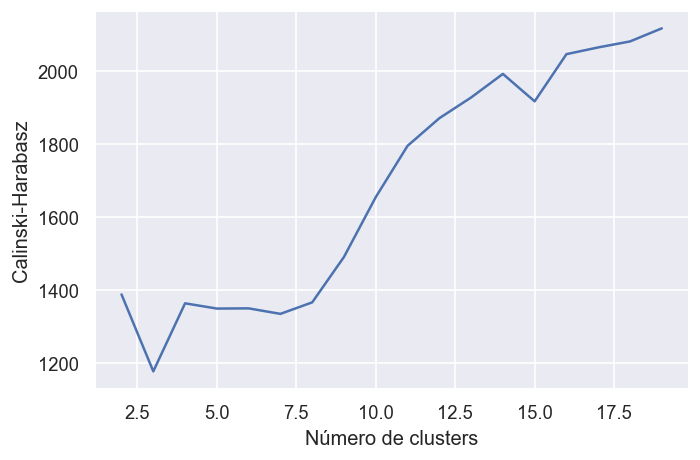

In [133]:
sns.lineplot(data=kmeans_metrics, x="Número de clusters", y="Calinski-Harabasz")

<AxesSubplot:xlabel='Número de clusters', ylabel='Davies-Bouldin'>

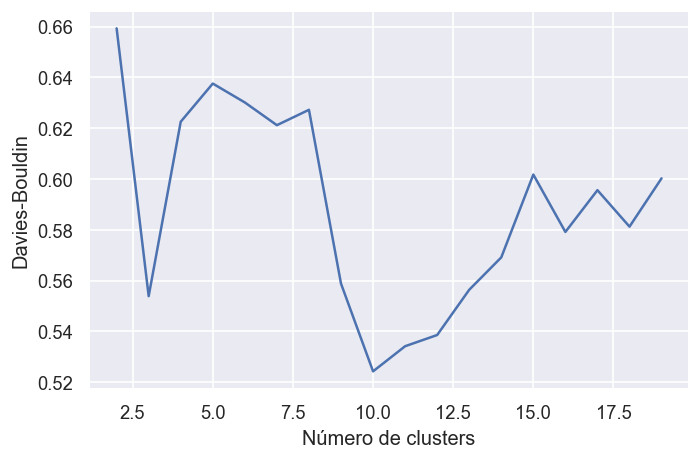

In [54]:
sns.lineplot(data=kmeans_metrics, x="Número de clusters", y="Davies-Bouldin")

<AxesSubplot:xlabel='Número de clusters', ylabel='Silhouette'>

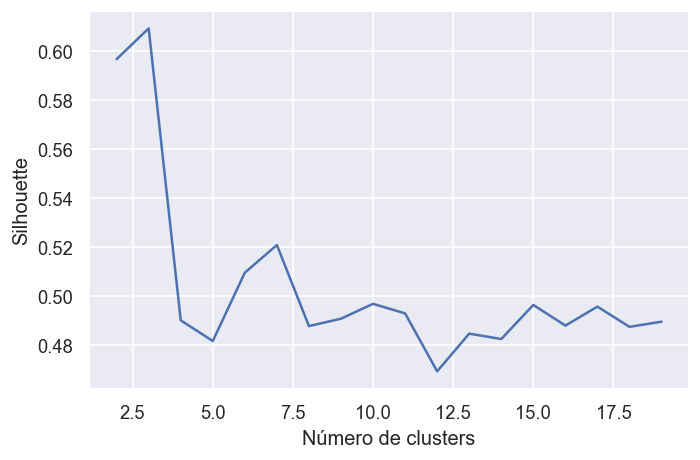

In [55]:
sns.lineplot(data=kmeans_metrics, x="Número de clusters", y="Silhouette")

### Análisis Birch

In [144]:
birch_ch = pd.DataFrame(columns=case.columns)
birch_X_clusters = algorithms[0].instances[0]['X_clusters']
for cluster in algorithms[0].instances[0]['cluster_ids']:
    quantiles = birch_X_clusters[birch_X_clusters['cluster']==cluster].quantile([.25, .75])
    d = {}
    for col in case.columns:
        d[col] = f"{quantiles.loc[.25][col]:.2f}-{quantiles.loc[.75][col]:.2f}"
    birch_ch.loc[cluster] = d
print(birch_ch.to_latex())

\begin{tabular}{lllll}
\toprule
{} &   renta\_disponible & ayuda\_familia\_hijos & asistencia\_social & ayuda\_vivienda \\
\midrule
0 &   9458.05-16916.11 &           0.00-0.00 &         0.00-0.00 &      0.00-0.00 \\
1 &  43180.67-55023.05 &           0.00-0.00 &         0.00-0.00 &      0.00-0.00 \\
2 &  14132.70-31845.70 &     2400.00-4320.00 &         0.00-0.00 &      0.00-0.00 \\
3 &  69605.30-82486.25 &           0.00-0.00 &         0.00-0.00 &      0.00-0.00 \\
4 &  23686.33-31690.17 &           0.00-0.00 &         0.00-0.00 &      0.00-0.00 \\
\bottomrule
\end{tabular}



In [88]:
birch = ClusterAlgorithm(Birch, name='Birch', centroid_attr='subcluster_centers_', not_instantiate=True)

In [89]:
birch.add_instances_product({
    'branching_factor': range(10, 45, 5),
    'threshold': [0.01, 0.05, 0.1, 0.15],
    'n_clusters': [5]
})

range(10, 45, 5) [0.01, 0.05, 0.1, 0.15] [5]


In [90]:
birch

<ClusterAlgorithm [Birch], 28 instances:
	branching_factor=10, threshold=0.01, n_clusters=5;
	branching_factor=10, threshold=0.05, n_clusters=5;
	branching_factor=10, threshold=0.1, n_clusters=5;
	branching_factor=10, threshold=0.15, n_clusters=5;
	branching_factor=15, threshold=0.01, n_clusters=5;
	branching_factor=15, threshold=0.05, n_clusters=5;
	branching_factor=15, threshold=0.1, n_clusters=5;
	branching_factor=15, threshold=0.15, n_clusters=5;
	branching_factor=20, threshold=0.01, n_clusters=5;
	branching_factor=20, threshold=0.05, n_clusters=5;
	branching_factor=20, threshold=0.1, n_clusters=5;
	branching_factor=20, threshold=0.15, n_clusters=5;
	branching_factor=25, threshold=0.01, n_clusters=5;
	branching_factor=25, threshold=0.05, n_clusters=5;
	branching_factor=25, threshold=0.1, n_clusters=5;
	branching_factor=25, threshold=0.15, n_clusters=5;
	branching_factor=30, threshold=0.01, n_clusters=5;
	branching_factor=30, threshold=0.05, n_clusters=5;
	branching_factor=30, thres

In [91]:
birch.run_instances(case, verbose=True)

[Birch] Running instance branching_factor=10, threshold=0.01, n_clusters=5...
[Birch] Running instance branching_factor=10, threshold=0.05, n_clusters=5...
[Birch] Running instance branching_factor=10, threshold=0.1, n_clusters=5...
[Birch] Running instance branching_factor=10, threshold=0.15, n_clusters=5...
[Birch] Running instance branching_factor=15, threshold=0.01, n_clusters=5...
[Birch] Running instance branching_factor=15, threshold=0.05, n_clusters=5...
[Birch] Running instance branching_factor=15, threshold=0.1, n_clusters=5...
[Birch] Running instance branching_factor=15, threshold=0.15, n_clusters=5...
[Birch] Running instance branching_factor=20, threshold=0.01, n_clusters=5...
[Birch] Running instance branching_factor=20, threshold=0.05, n_clusters=5...
[Birch] Running instance branching_factor=20, threshold=0.1, n_clusters=5...
[Birch] Running instance branching_factor=20, threshold=0.15, n_clusters=5...
[Birch] Running instance branching_factor=25, threshold=0.01, n_clu

In [92]:
birch.calculate_metrics(cluster.metrics, verbose=True)

[Birch] Calculating metrics in instance branching_factor=10, threshold=0.01, n_clusters=5...
[Birch] Calculating metrics in instance branching_factor=10, threshold=0.05, n_clusters=5...
[Birch] Calculating metrics in instance branching_factor=10, threshold=0.1, n_clusters=5...
[Birch] Calculating metrics in instance branching_factor=10, threshold=0.15, n_clusters=5...
[Birch] Calculating metrics in instance branching_factor=15, threshold=0.01, n_clusters=5...
[Birch] Calculating metrics in instance branching_factor=15, threshold=0.05, n_clusters=5...
[Birch] Calculating metrics in instance branching_factor=15, threshold=0.1, n_clusters=5...
[Birch] Calculating metrics in instance branching_factor=15, threshold=0.15, n_clusters=5...
[Birch] Calculating metrics in instance branching_factor=20, threshold=0.01, n_clusters=5...
[Birch] Calculating metrics in instance branching_factor=20, threshold=0.05, n_clusters=5...
[Birch] Calculating metrics in instance branching_factor=20, threshold=0

In [93]:
birch_metrics = pd.DataFrame(columns=['Umbral', 'Factor de ramificación'] + list(cluster.metrics.keys()))
for i, instance in enumerate(birch.instances):
    d = instance['metrics']
    d['Umbral'], d['Factor de ramificación'] = instance['instance_values']['threshold'], instance['instance_values']['branching_factor']
    birch_metrics.loc[i] = d
birch_metrics

,Umbral,Factor de ramificación,Tiempo,Calinski-Harabasz,Davies-Bouldin,Silhouette,Número de clusters
0,0.01,10,0.270074,961.051484,0.534130,0.509498,5
1,0.05,10,0.320712,442.707246,0.423138,0.643526,5
2,0.10,10,0.143869,527.890941,0.344149,0.631890,5
3,0.15,10,0.118283,256.611475,0.678905,0.550564,5
4,0.01,15,0.229861,550.519834,0.375209,0.636391,5
5,0.05,15,0.191177,437.381727,0.328507,0.637046,5
6,0.10,15,0.105700,520.374113,0.342738,0.632595,5
7,0.15,15,0.110058,256.611475,0.678905,0.550564,5
8,0.01,20,0.184067,1065.859659,0.531999,0.513194,5
9,0.05,20,0.136053,478.306766,0.600981,0.597465,5


In [146]:
print(birch_metrics.to_latex(index=False))

\begin{tabular}{rlrrrrl}
\toprule
 Umbral & Factor de ramificación &   Tiempo &  Calinski-Harabasz &  Davies-Bouldin &  Silhouette & Número de clusters \\
\midrule
   0.01 &                     10 & 0.270074 &         961.051484 &        0.534130 &    0.509498 &                  5 \\
   0.05 &                     10 & 0.320712 &         442.707246 &        0.423138 &    0.643526 &                  5 \\
   0.10 &                     10 & 0.143869 &         527.890941 &        0.344149 &    0.631890 &                  5 \\
   0.15 &                     10 & 0.118283 &         256.611475 &        0.678905 &    0.550564 &                  5 \\
   0.01 &                     15 & 0.229861 &         550.519834 &        0.375209 &    0.636391 &                  5 \\
   0.05 &                     15 & 0.191177 &         437.381727 &        0.328507 &    0.637046 &                  5 \\
   0.10 &                     15 & 0.105700 &         520.374113 &        0.342738 &    0.632595 &            

<AxesSubplot:xlabel='Umbral', ylabel='Calinski-Harabasz'>

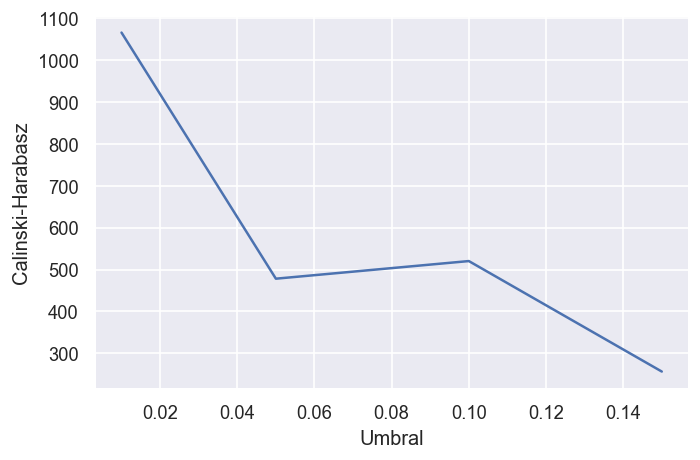

In [94]:
# fijado factor de ramificación = 20
sns.lineplot(data=birch_metrics[birch_metrics['Factor de ramificación']==20], x="Umbral", y="Calinski-Harabasz")

<AxesSubplot:xlabel='Umbral', ylabel='Davies-Bouldin'>

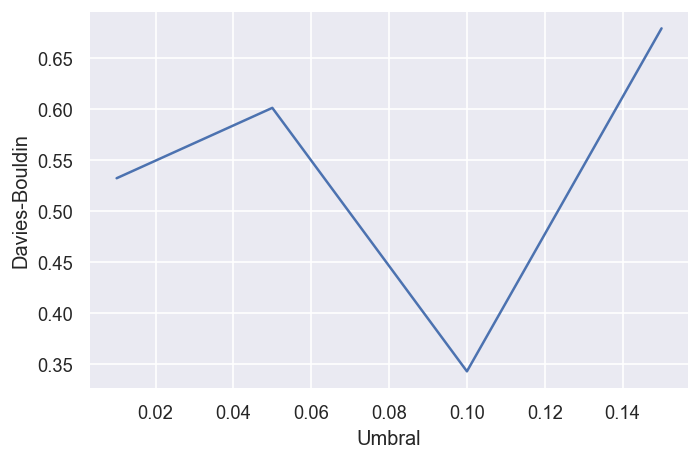

In [95]:
# fijado factor de ramificación = 20
sns.lineplot(data=birch_metrics[birch_metrics['Factor de ramificación']==20], x="Umbral", y="Davies-Bouldin")

<AxesSubplot:xlabel='Umbral', ylabel='Silhouette'>

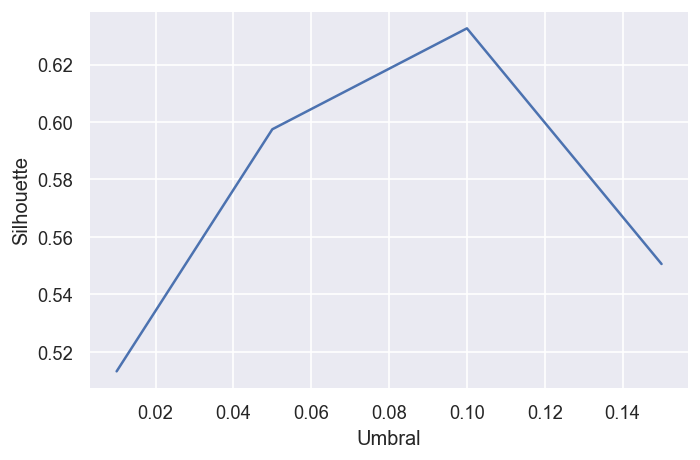

In [96]:
# fijado factor de ramificación = 20
sns.lineplot(data=birch_metrics[birch_metrics['Factor de ramificación']==20], x="Umbral", y="Silhouette")

<AxesSubplot:xlabel='Umbral', ylabel='Calinski-Harabasz'>

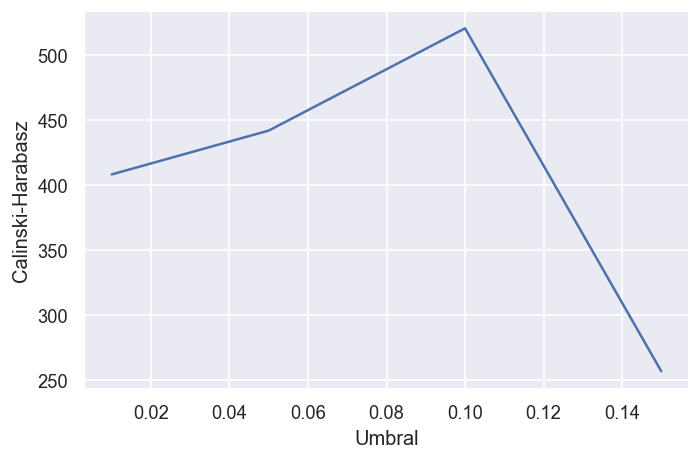

In [97]:
# fijado factor de ramificación = 40
sns.lineplot(data=birch_metrics[birch_metrics['Factor de ramificación']==40], x="Umbral", y="Calinski-Harabasz")

<AxesSubplot:xlabel='Umbral', ylabel='Davies-Bouldin'>

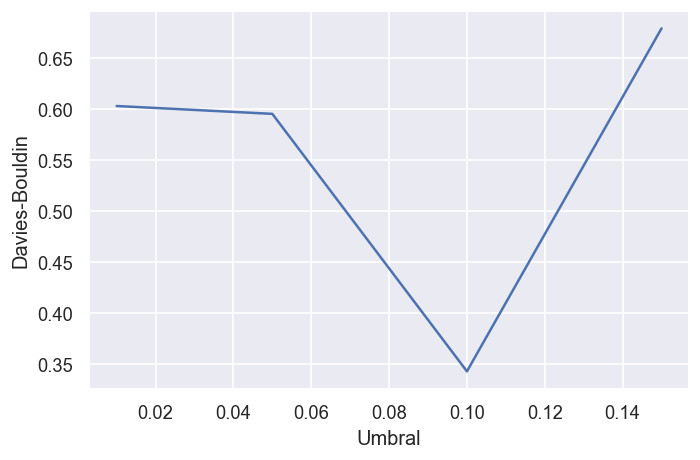

In [98]:
# fijado factor de ramificación = 40
sns.lineplot(data=birch_metrics[birch_metrics['Factor de ramificación']==40], x="Umbral", y="Davies-Bouldin")

<AxesSubplot:xlabel='Umbral', ylabel='Silhouette'>

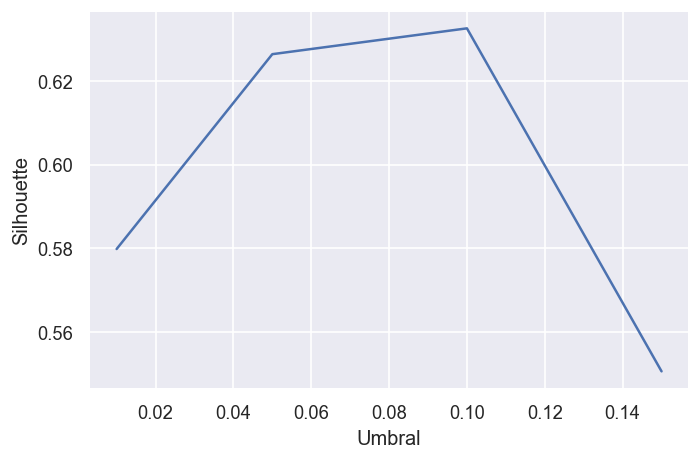

In [99]:
# fijado factor de ramificación = 40
sns.lineplot(data=birch_metrics[birch_metrics['Factor de ramificación']==40], x="Umbral", y="Silhouette")

<AxesSubplot:xlabel='Factor de ramificación', ylabel='Calinski-Harabasz'>

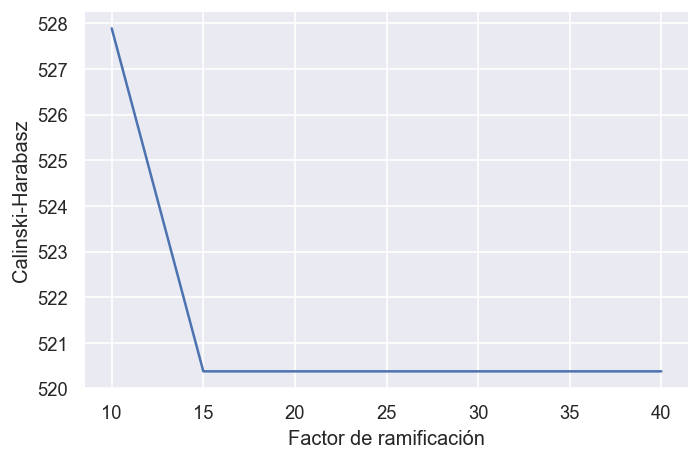

In [100]:
# fijado umbral = 0.1
sns.lineplot(data=birch_metrics[birch_metrics['Umbral']==.1], x="Factor de ramificación", y="Calinski-Harabasz")

<AxesSubplot:xlabel='Factor de ramificación', ylabel='Davies-Bouldin'>

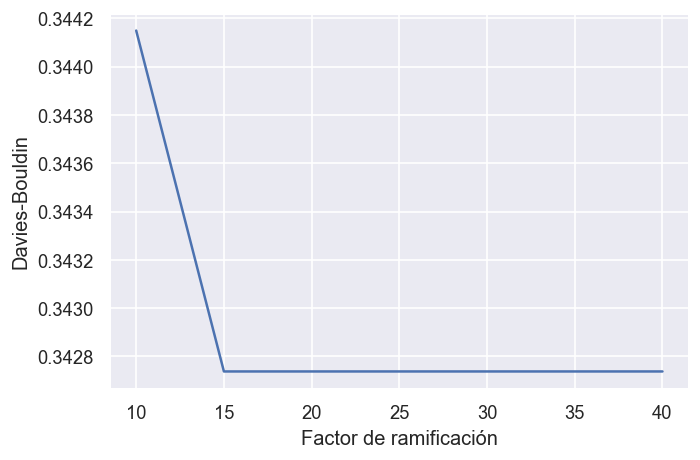

In [102]:
# fijado umbral = 0.1
sns.lineplot(data=birch_metrics[birch_metrics['Umbral']==.1], x="Factor de ramificación", y="Davies-Bouldin")

<AxesSubplot:xlabel='Factor de ramificación', ylabel='Silhouette'>

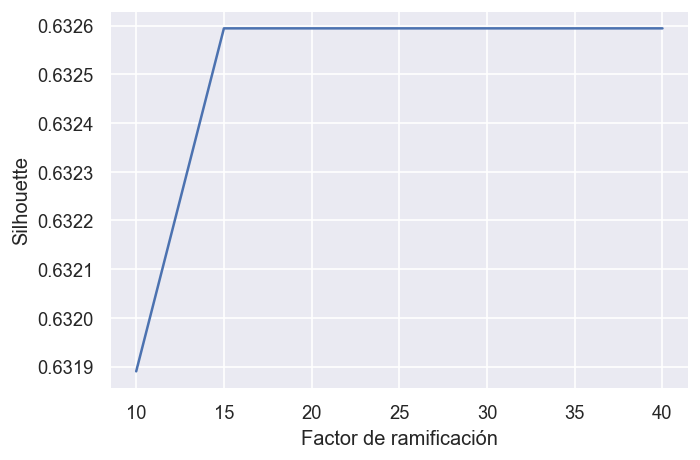

In [103]:
# fijado umbral = 0.1
sns.lineplot(data=birch_metrics[birch_metrics['Umbral']==.1], x="Factor de ramificación", y="Silhouette")

<AxesSubplot:xlabel='Factor de ramificación', ylabel='Calinski-Harabasz'>

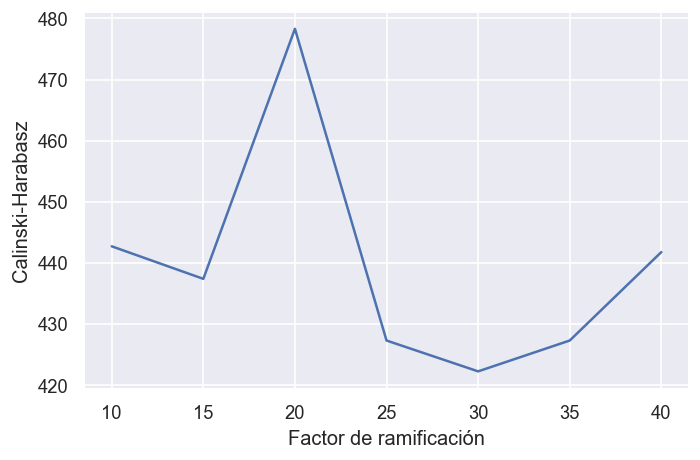

In [104]:
# fijado umbral = 0.05
sns.lineplot(data=birch_metrics[birch_metrics['Umbral']==.05], x="Factor de ramificación", y="Calinski-Harabasz")

<AxesSubplot:xlabel='Factor de ramificación', ylabel='Davies-Bouldin'>

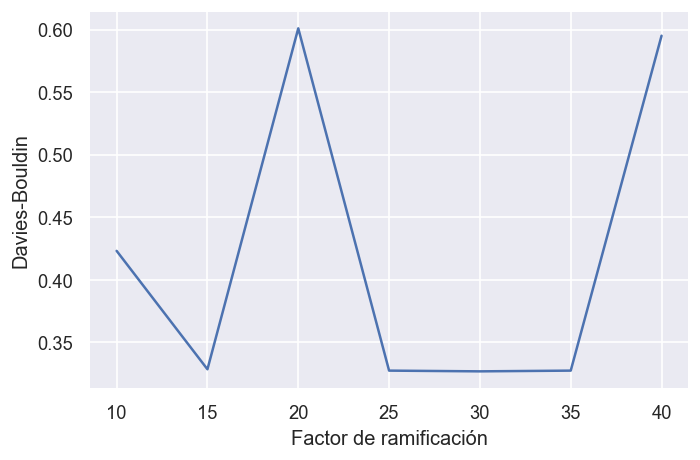

In [105]:
# fijado umbral = 0.05
sns.lineplot(data=birch_metrics[birch_metrics['Umbral']==.05], x="Factor de ramificación", y="Davies-Bouldin")

<AxesSubplot:xlabel='Factor de ramificación', ylabel='Silhouette'>

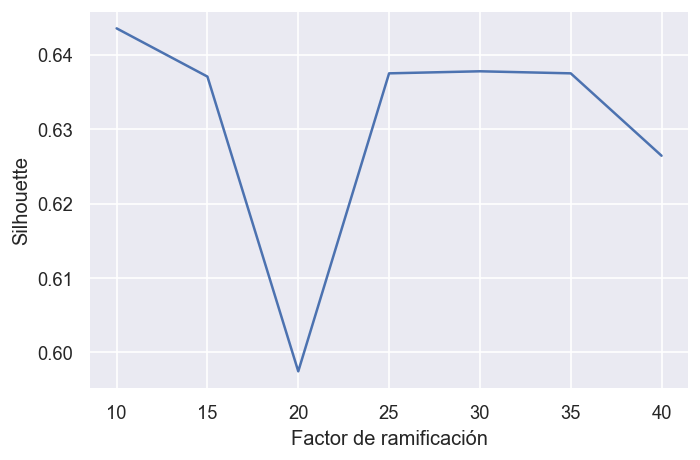

In [106]:
# fijado umbral = 0.05
sns.lineplot(data=birch_metrics[birch_metrics['Umbral']==.05], x="Factor de ramificación", y="Silhouette")

### Análisis adicional: diferencias de ayudas entre Comunidades Autónomas